# Augmentation Analysis - Clean Workflow (with NEW augmentation types)

This notebook analyzes how data augmentation affects track classification.

## Workflow Structure

### PHASE 1: DATA PREPARATION (scaling on FULL data)
1. **Setup**: Imports, configuration, load data
2. **Clean**: Remove ungated populations
3. **Select**: Pick N parent window_uids from FULL data (before train/test split)
4. **Augment**: Apply noise and scale augmentations to selected parent tracks
5. **Calculate**: Compute features (speed, self-intersections, alpha, cumulative distance)
6. **Combine**: Add children to FULL windowed_df, labeling parent/child relationships
7. **Scale & Gate**: Fit scaler on COMBINED data, apply gating to classify ALL tracks
8. **Split**: Create train/val/test split (AFTER gating, so scaler sees full data)
9. **Filter**: Extract only parent and child tracks for analysis

### PHASE 2: VISUALIZATION
10. **Small selection**: Sample 20 tracks per behavior for detailed visualization
    - Track plots (rows=tracks, columns=augmentations)
    - Feature space (X/Y) plots
11. **Large selection**: Stability heatmap showing which augmentations cause population changes

---

In [1]:
# =============================================================================
# CELL 1: IMPORTS
# =============================================================================

import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import os
from pathlib import Path
from datetime import datetime
from tqdm.notebook import tqdm
import scipy.optimize

import SPTnano as spt
from SPTnano.visualization import plot_augmentation_movement, plot_population_stability_heatmap
from SPTnano.transformer import create_smart_train_val_test_split

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

# =============================================================================
# AUGMENTATION FUNCTIONS (inline - simple trajectory augmentation)
# =============================================================================

def augment_noise(x, y, noise, seed):
    """Add Gaussian noise to trajectory displacements (ADDITIVE)"""
    np.random.seed(seed)
    dx, dy = np.diff(x, prepend=x[0]), np.diff(y, prepend=y[0])
    return np.cumsum(dx + noise*np.random.randn(len(dx))), np.cumsum(dy + noise*np.random.randn(len(dy)))

def augment_scale(x, y, scale, seed):
    """Scale trajectory displacements by random factor within range"""
    np.random.seed(seed)
    dx, dy = np.diff(x, prepend=x[0]), np.diff(y, prepend=y[0])
    f = 1.0 + (np.random.rand()*2-1)*scale
    return np.cumsum(dx*f), np.cumsum(dy*f), f

# =============================================================================
# NEW AUGMENTATION FUNCTIONS
# =============================================================================

def augment_rotation(x, y, angle_deg, seed):
    """Rotate entire trajectory by angle (degrees). If angle_deg=None, random [0-360]."""
    np.random.seed(seed)
    if angle_deg is None:
        angle_deg = np.random.rand() * 360
    angle_rad = np.deg2rad(angle_deg)
    # Center, rotate, then shift back
    cx, cy = x.mean(), y.mean()
    x_c, y_c = x - cx, y - cy
    x_rot = x_c * np.cos(angle_rad) - y_c * np.sin(angle_rad)
    y_rot = x_c * np.sin(angle_rad) + y_c * np.cos(angle_rad)
    return x_rot + cx, y_rot + cy

def augment_reversal(x, y, seed):
    """Time reversal - play track backwards. Returns reversed arrays."""
    # No randomness needed, but seed for consistency
    return x[::-1].copy(), y[::-1].copy()

def augment_proportional_noise(x, y, scale, seed):
    """Multiplicative noise: dx * (1 + ε) where ε ~ N(0, scale). Gentler than additive."""
    np.random.seed(seed)
    dx, dy = np.diff(x, prepend=x[0]), np.diff(y, prepend=y[0])
    noise_x = 1.0 + scale * np.random.randn(len(dx))
    noise_y = 1.0 + scale * np.random.randn(len(dy))
    return np.cumsum(dx * noise_x), np.cumsum(dy * noise_y)

def augment_velocity_smoothing(x, y, window, seed):
    """Smooth displacements with moving average. window=3 means 3-point average."""
    from scipy.ndimage import uniform_filter1d
    dx, dy = np.diff(x, prepend=x[0]), np.diff(y, prepend=y[0])
    dx_smooth = uniform_filter1d(dx, size=window, mode='nearest')
    dy_smooth = uniform_filter1d(dy, size=window, mode='nearest')
    return np.cumsum(dx_smooth), np.cumsum(dy_smooth)

def augment_frame_dropout(x, y, dropout_rate, seed):
    """Drop frames randomly and interpolate. dropout_rate=0.1 means drop 10%."""
    np.random.seed(seed)
    n = len(x)
    keep_mask = np.random.rand(n) > dropout_rate
    keep_mask[0] = True  # Always keep first
    keep_mask[-1] = True  # Always keep last
    
    indices = np.arange(n)
    kept_indices = indices[keep_mask]
    
    # Interpolate back to original length
    x_interp = np.interp(indices, kept_indices, x[keep_mask])
    y_interp = np.interp(indices, kept_indices, y[keep_mask])
    return x_interp, y_interp

def augment_temporal_jitter(x, y, jitter, seed):
    """Jitter frame timing by resampling with small time offsets."""
    np.random.seed(seed)
    n = len(x)
    # Original "time" indices
    t_orig = np.arange(n, dtype=float)
    # Jittered time (add small random offsets, keep monotonic)
    t_jitter = t_orig + jitter * np.random.randn(n)
    t_jitter = np.sort(t_jitter)  # Ensure monotonic
    t_jitter = np.clip(t_jitter, 0, n-1)  # Keep in bounds
    
    # Interpolate x,y at jittered times (then sample back at original times)
    x_jitter = np.interp(t_orig, t_jitter, x)
    y_jitter = np.interp(t_orig, t_jitter, y)
    return x_jitter, y_jitter

def augment_bidirectional_scale(x, y, scale, seed):
    """Scale with explicit up OR down choice (not random within range)."""
    np.random.seed(seed)
    dx, dy = np.diff(x, prepend=x[0]), np.diff(y, prepend=y[0])
    # 50/50 chance of scaling up or down
    direction = 1 if np.random.rand() > 0.5 else -1
    f = 1.0 + direction * scale
    return np.cumsum(dx*f), np.cumsum(dy*f), f

print("✅ Imports complete!")

Config module loaded. Master directory is: D:/TRANSFORMER_DEVELOPMENT/
✅ Imports complete!


In [2]:
# =============================================================================
# CELL 2: CONFIGURATION
# =============================================================================

# --- DRIVE PATHS (adjust for your system) ---
DATA_DRIVE = 'F:'
MODEL_DRIVE = 'F:'
OUTPUT_DRIVE = 'D:'

# --- DATA PATHS ---
DATA_DIR = f"{DATA_DRIVE}/Analyzed/HIERARCHICAL_GATES_20260119_102840"
INSTANT_DF_PATH = os.path.join(DATA_DIR, 'instant_df_hierarchical_gates.parquet')
WINDOWED_DF_PATH = os.path.join(DATA_DIR, 'windowed_df_hierarchical_gates.parquet')
SPLITS_PATH = f"{MODEL_DRIVE}/TRANSFORMER_DEVELOPMENT/saved_data/models/data_splits_withheirarchalgates.pkl"

# --- OUTPUT ---
OUTPUT_FOLDER = Path(f"{OUTPUT_DRIVE}/TRANSFORMER_DEVELOPMENT/plots/augmentation_analysis")
OUTPUT_FOLDER.mkdir(parents=True, exist_ok=True)

# --- AUGMENTATION SETTINGS ---
N_LARGE_SELECTION = 60   # Tracks per population for heatmaps
N_SMALL_SELECTION = 20     # Tracks per population for detailed visualization

# Original augmentation types (multi-level)
NOISE_LEVELS = [0.001, 0.002, 0.005, 0.01, 0.02]          # Additive Gaussian noise
SCALE_LEVELS = [0.05, 0.1, 0.2, 0.3, 0.4]            # Random scale within range

# NEW AUGMENTATION TYPES
# Each dict entry: {type_name: {'levels': [...], 'enabled': bool}}
# - For multi-level augs: 'levels' is a list of values to try
# - For single-level augs: 'levels' is [True] or [value] (just one)

# AUGMENTATION_CONFIG = {
#     # --- ORIGINAL TYPES ---
#     'noise': {
#         'levels': NOISE_LEVELS,
#         'enabled': True,
#         'description': 'Additive Gaussian noise to displacements'
#     },
#     'scale': {
#         'levels': SCALE_LEVELS,
#         'enabled': True,
#         'description': 'Random scale factor ±range'
#     },
#     # --- NEW TYPES ---
#     'rotation': {
#         'levels': [True],  # Single-level: just apply random rotation
#         'enabled': True,
#         'description': 'Random rotation (0-360°)'
#     },
#     'reversal': {
#         'levels': [True],  # Single-level: reverse or not
#         'enabled': True,
#         'description': 'Time reversal (play backwards)'
#     },
#     'proportional_noise': {
#         'levels': [0.02, 0.05, 0.1, 0.15, 0.2],  # Multiplicative scale
#         'enabled': True,
#         'description': 'Multiplicative noise (gentler than additive)'
#     },
#     'velocity_smoothing': {
#         'levels': [3, 5, 7, 9],  # Window sizes
#         'enabled': True,
#         'description': 'Moving average smoothing of velocities'
#     },
#     'frame_dropout': {
#         'levels': [0.05, 0.1, 0.15, 0.2, 0.25],  # Dropout rates
#         'enabled': True,
#         'description': 'Random frame dropout + interpolation'
#     },
#     'temporal_jitter': {
#         'levels': [0.2, 0.5, 1.0, 1.5, 2.0],  # Jitter amount (frames)
#         'enabled': True,
#         'description': 'Small random time offsets'
#     },
#     'bidirectional_scale': {
#         'levels': [0.05, 0.1, 0.2, 0.3, 0.4],  # Scale amounts
#         'enabled': True,
#         'description': 'Scale explicitly up OR down (50/50)'
#     },
# }
AUGMENTATION_CONFIG = {
    # --- ORIGINAL TYPES ---
    'noise': {
        'levels':[0.001, 0.002, 0.005, 0.01, 0.02],
        'enabled': True,
        'description': 'Additive Gaussian noise to displacements'
    },
    'scale': {
        'levels': [0.05, 0.1, 0.15, 0.2,] ,
        'enabled': True,
        'description': 'Random scale factor ±range'
    },
    # --- NEW TYPES ---
    'rotation': {
        'levels': [True],  # Single-level: just apply random rotation
        'enabled': True,
        'description': 'Random rotation (0-360°)'
    },
    'reversal': {
        'levels': [True],  # Single-level: reverse or not
        'enabled': True,
        'description': 'Time reversal (play backwards)'
    },
    'proportional_noise': {
        'levels': [0.01, 0.02, 0.03, 0.05,],  # Multiplicative scale
        'enabled': True,
        'description': 'Multiplicative noise (gentler than additive)'
    },
    'velocity_smoothing': {
        'levels': [1,2,3],  # Window sizes
        'enabled': True,
        'description': 'Moving average smoothing of velocities'
    },
    'frame_dropout': {
        'levels': [0.01,0.02,0.03,0.05],#[0.05,0.06],  # Dropout rates
        'enabled': True,
        'description': 'Random frame dropout + interpolation'
    },
    'temporal_jitter': {
        'levels': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],  # Jitter amount (frames)
        'enabled': True,
        'description': 'Small random time offsets'
    },
    'bidirectional_scale': {
        'levels': [0.05, 0.075, 0.1, 0.2,],  # Scale amounts
        'enabled': True,
        'description': 'Scale explicitly up OR down (50/50)'
    },
}
# Helper: get enabled augmentations
def get_enabled_augmentations():
    return {k: v for k, v in AUGMENTATION_CONFIG.items() if v['enabled']}

# --- GATING SETTINGS ---
GATE1_BOUNDS = {
    'low_speed_low_intersections': (0.0, 0.2, 0.0, 0.14),
    'high_speed_low_intersections': (0.2, 1.0, 0.0, 0.14),
    'low_speed_high_intersections': (0.0, 0.3, 0.14, 1.0),
    'high_speed_high_intersections': (0.3, 1.0, 0.14, 1.0),
}

SEED = 42
np.random.seed(SEED)

print("🔧 Configuration:")
print(f"   Data: {DATA_DIR}")
print(f"   Output: {OUTPUT_FOLDER}")
print(f"   Large selection: {N_LARGE_SELECTION} per population")
print(f"   Small selection: {N_SMALL_SELECTION} per population")
print(f"   Noise levels: {AUGMENTATION_CONFIG['noise']['levels']}")
print(f"   Scale levels: {AUGMENTATION_CONFIG['scale']['levels']}")
# print(f"   Rotation levels: {AUGMENTATION_CONFIG['rotation']['levels']}")
# print(f"   Reversal levels: {AUGMENTATION_CONFIG['reversal']['levels']}")
print(f"   Proportional noise levels: {AUGMENTATION_CONFIG['proportional_noise']['levels']}")
print(f"   Velocity smoothing levels: {AUGMENTATION_CONFIG['velocity_smoothing']['levels']}")
print(f"   Frame dropout levels: {AUGMENTATION_CONFIG['frame_dropout']['levels']}")
print(f"   Temporal jitter levels: {AUGMENTATION_CONFIG['temporal_jitter']['levels']}")
print(f"   Bidirectional scale levels: {AUGMENTATION_CONFIG['bidirectional_scale']['levels']}")

🔧 Configuration:
   Data: F:/Analyzed/HIERARCHICAL_GATES_20260119_102840
   Output: D:\TRANSFORMER_DEVELOPMENT\plots\augmentation_analysis
   Large selection: 60 per population
   Small selection: 20 per population
   Noise levels: [0.001, 0.002, 0.005, 0.01, 0.02]
   Scale levels: [0.05, 0.1, 0.15, 0.2]
   Proportional noise levels: [0.01, 0.02, 0.03, 0.05]
   Velocity smoothing levels: [1, 2, 3]
   Frame dropout levels: [0.01, 0.02, 0.03, 0.05]
   Temporal jitter levels: [0.001, 0.005, 0.01, 0.02, 0.05, 0.1]
   Bidirectional scale levels: [0.05, 0.075, 0.1, 0.2]


In [3]:
# =============================================================================
# CELL 3: LOAD DATA
# =============================================================================

print("📂 Loading dataframes...")

instant_df = pl.read_parquet(INSTANT_DF_PATH)
windowed_df = pl.read_parquet(WINDOWED_DF_PATH)

# Update drive letters if needed
instant_df = instant_df.with_columns(pl.col('foldername').str.replace('Z:', DATA_DRIVE))
windowed_df = windowed_df.with_columns(pl.col('foldername').str.replace('Z:', DATA_DRIVE))

# Remove bad fits
print(f"   Before filtering: {windowed_df.shape[0]:,} windows")
windowed_df = windowed_df.filter(pl.col('bad_fit_flag') == False)
print(f"   After filtering:  {windowed_df.shape[0]:,} windows")

# Filter instant_df to match windowed_df
unique_window_uids = windowed_df.select(pl.col('window_uid')).unique()
instant_df = instant_df.filter(pl.col('window_uid').is_in(unique_window_uids['window_uid'].to_list()))

print(f"\n✅ Data loaded:")
print(f"   Windowed: {windowed_df.shape}")
print(f"   Instant:  {instant_df.shape}")

📂 Loading dataframes...
   Before filtering: 913,243 windows
   After filtering:  913,243 windows

✅ Data loaded:
   Windowed: (913243, 68)
   Instant:  (34985340, 51)


In [4]:
# =============================================================================
# CELL 4: REMOVE UNGATED POPULATIONS (before any splits or augmentation)
# =============================================================================

ungated_names = ['ungated', 'ungatedgate1', 'ungatedgate2']

print(f"Before filtering:")
print(f"   Windowed: {windowed_df.shape[0]:,} rows")
print(f"   Instant:  {instant_df.shape[0]:,} rows")

# Filter windowed_df
windowed_df = windowed_df.filter(~pl.col('final_population').is_in(ungated_names))

# Filter instant_df to match
gated_window_uids = windowed_df.select('window_uid').unique()
instant_df = instant_df.filter(pl.col('window_uid').is_in(gated_window_uids['window_uid'].to_list()))

print(f"\nAfter removing ungated populations:")
print(f"   Windowed: {windowed_df.shape[0]:,} rows")
print(f"   Instant:  {instant_df.shape[0]:,} rows")

populations = windowed_df['final_population'].unique().to_list()
print(f"\n✅ Remaining populations: {populations}")

Before filtering:
   Windowed: 913,243 rows
   Instant:  34,985,340 rows

After removing ungated populations:
   Windowed: 913,237 rows
   Instant:  34,985,130 rows

✅ Remaining populations: ['superdiffusive_transport', 'bound_stationary', 'subdiffusive_motion', 'mixed_exploratory_bound', 'fast_exploratory']


In [5]:
# =============================================================================
# CELL 5: HELPER FUNCTIONS (parse window_uid, get frames, compute features)
# =============================================================================
# Moved up so they are available for augmentation

def parse_window_uid(wuid):
    """Parse window_uid to extract unique_id, frame_start, frame_end"""
    parts = wuid.rsplit('_', 2)
    frame_end = float(parts[-1])
    frame_start = float(parts[-2])
    unique_id = '_'.join(parts[:-2]).rsplit('_', 1)[0]
    return unique_id, int(frame_start), int(frame_end)

def get_window_frames(df, wuid):
    """Get frames for a window by parsing window_uid"""
    unique_id, frame_start, frame_end = parse_window_uid(wuid)
    return df.filter(
        (pl.col('unique_id') == unique_id) &
        (pl.col('frame') >= frame_start) &
        (pl.col('frame') <= frame_end)
    ).sort('frame')

def calculate_self_intersections(x, y):
    """Calculate number of self-intersections in trajectory"""
    n_points = len(x)
    if n_points < 4:
        return 0
    points = np.column_stack([x, y])
    def ccw(a, b, c):
        return (c[1] - a[1]) * (b[0] - a[0]) > (b[1] - a[1]) * (c[0] - a[0])
    def intersect(a, b, c, d):
        return ccw(a, c, d) != ccw(b, c, d) and ccw(a, b, c) != ccw(a, b, d)
    count = 0
    for i in range(n_points - 1):
        for j in range(i + 2, n_points - 1):
            if intersect(points[i], points[i+1], points[j], points[j+1]):
                count += 1
    return count

def compute_augmented_features(x, y, delta_time_s):
    """Compute features for augmented trajectory (matches features.py EXACTLY)
    
    Uses the SAME MSD fitting method as features.py:
    - scipy.optimize.curve_fit with MSD = 4*D*t^alpha
    - ALL lag times (not just first 25%)
    - Non-linear least squares in linear space
    
    Args:
        x, y: coordinate arrays (length N)
        delta_time_s: Array of per-frame time deltas (length N, first value is NaN/0)
                      - Pass track_df['delta_time_s'].to_numpy() for EXACT match with features.py
                      - Or pass a scalar for constant dt fallback
    """
    # Displacements (N-1 values)
    dx = np.diff(x)
    dy = np.diff(y)
    step_lengths = np.sqrt(dx**2 + dy**2)
    
    # Speed calculation - use actual delta_time_s like features.py does
    if np.isscalar(delta_time_s):
        # Constant dt fallback
        dt = delta_time_s
        speeds = step_lengths / delta_time_s
    else:
        # Use actual per-frame delta_time_s (skip first which is NaN/0)
        dt_array = np.asarray(delta_time_s)[1:]  # Skip first frame (no delta)
        # Avoid division by zero
        dt_array = np.where((dt_array == 0) | np.isnan(dt_array), 1e-10, dt_array)
        speeds = step_lengths / dt_array
        # Use median dt for MSD calculation
        dt = np.nanmedian(dt_array)
    
    avg_speed = np.mean(speeds)
    
    # CUMULATIVE displacement = SUM of all step lengths (total path length)
    cum_disp = np.sum(step_lengths)
    
    # Self-intersections - RAW COUNT, not normalized!
    n_intersections = calculate_self_intersections(x, y)
    
    # ==========================================================================
    # MSD and anomalous exponent - MATCHING features.py EXACTLY
    # ==========================================================================
    # Use ALL lag times like features.py (not just first 25%)
    n_points = len(x)
    lag_times = np.arange(1, n_points) * dt  # ALL lags, in seconds
    msd_values = np.zeros(len(lag_times))
    
    for i, lag in enumerate(range(1, n_points)):
        displacements = (x[lag:] - x[:-lag])**2 + (y[lag:] - y[:-lag])**2
        msd_values[i] = np.mean(displacements)
    
    # MSD model: MSD(t) = 4 * D * t^alpha (same as features.py)
    def msd_model(t, D, alpha):
        return 4 * D * np.power(t, alpha)
    
    # Fit using scipy.optimize.curve_fit (same as features.py)
    if len(lag_times) >= 3:
        try:
            popt, _ = scipy.optimize.curve_fit(
                msd_model, 
                lag_times, 
                msd_values,
                p0=[0.1, 1.0],  # Initial guess: D=0.1, alpha=1.0
                bounds=([0, 0], [np.inf, 3.0]),  # D>0, 0<alpha<3
                maxfev=5000
            )
            alpha = popt[1]
        except (RuntimeError, ValueError):
            # Fallback to log-log linear fit if curve_fit fails
            print('Falling back to log-log linear fit')
            valid = (lag_times > 0) & (msd_values > 0)
            if np.sum(valid) >= 2:
                log_lags = np.log(lag_times[valid])
                log_msd = np.log(msd_values[valid])
                coeffs = np.polyfit(log_lags, log_msd, 1)
                alpha = coeffs[0]
            else:
                alpha = 1.0
    else:
        alpha = 1.0
    
    return {
        'avg_speed_um_s': avg_speed,
        'cum_displacement_um': cum_disp,  # SUM of step lengths (total path)
        'self_intersections': n_intersections,  # RAW count, not normalized!
        'anomalous_exponent': alpha,
    }

print("✅ Helper functions defined")

✅ Helper functions defined


---
## PHASE 1: DATA PREPARATION
---

In [6]:
# =============================================================================
# CELL 6: SELECT PARENT WINDOW_UIDS FROM FULL DATA (COMPLETE FRAMES ONLY)
# =============================================================================
# Select N_LARGE_SELECTION window_uids from each behavior type from FULL data.
# IMPORTANT: Only select tracks with COMPLETE frames (no gaps in tracking)!
# This happens BEFORE train/test split so scaler sees all data.

print("=" * 70)
print("SELECT PARENT WINDOW_UIDS FROM FULL DATA (complete frames only)")
print("=" * 70)

def has_complete_frames(df, wuid):
    """Check if a window_uid has all expected frames (no gaps)"""
    unique_id, frame_start, frame_end = parse_window_uid(wuid)
    expected_frames = frame_end - frame_start + 1
    
    actual_frames = df.filter(
        (pl.col('unique_id') == unique_id) &
        (pl.col('frame') >= frame_start) &
        (pl.col('frame') <= frame_end)
    ).height
    
    return actual_frames == expected_frames

# Get populations from the FULL (gated) windowed_df
populations = [p for p in windowed_df['final_population'].unique().to_list() 
               if p and 'ungated' not in p.lower()]

print(f"📊 Full dataset: {windowed_df.shape[0]:,} windows")
print(f"   Populations: {populations}")
print(f"\n⏳ Filtering for tracks with COMPLETE frames (this may take a moment)...")

# Select parent window_uids from FULL data - only tracks with complete frames
selected_parents = {}  # {population: [window_uids]}
for pop in populations:
    pop_uids = windowed_df.filter(pl.col('final_population') == pop)['window_uid'].to_list()
    
    # Filter for complete tracks (sample more than we need, then filter)
    # Shuffle to get random sample
    np.random.shuffle(pop_uids)
    
    complete_uids = []
    checked = 0
    for uid in pop_uids:
        if has_complete_frames(instant_df, uid):
            complete_uids.append(uid)
            if len(complete_uids) >= N_LARGE_SELECTION:
                break
        checked += 1
        # Progress indicator every 500 checks
        if checked % 500 == 0:
            print(f"      {pop}: checked {checked}, found {len(complete_uids)} complete...")
    
    selected_parents[pop] = complete_uids
    print(f"   {pop}: {len(pop_uids):,} total → checked {checked} → found {len(complete_uids)} complete")

all_parent_uids = [uid for uids in selected_parents.values() for uid in uids]
print(f"\n✅ Selected {len(all_parent_uids):,} parent window_uids (all with COMPLETE frames)")

SELECT PARENT WINDOW_UIDS FROM FULL DATA (complete frames only)
📊 Full dataset: 913,237 windows
   Populations: ['mixed_exploratory_bound', 'superdiffusive_transport', 'subdiffusive_motion', 'fast_exploratory', 'bound_stationary']

⏳ Filtering for tracks with COMPLETE frames (this may take a moment)...
   mixed_exploratory_bound: 30,863 total → checked 165 → found 60 complete
   superdiffusive_transport: 16,441 total → checked 82 → found 60 complete
   subdiffusive_motion: 93,908 total → checked 81 → found 60 complete
   fast_exploratory: 557,990 total → checked 137 → found 60 complete
   bound_stationary: 214,035 total → checked 98 → found 60 complete

✅ Selected 300 parent window_uids (all with COMPLETE frames)


In [7]:
# =============================================================================
# CELL 7B: NEW AUGMENTATION PROCESSING (ALL TYPES)
# =============================================================================
# Run this cell INSTEAD of Cell 7 to use all augmentation types
# Uses ACTUAL delta_time_s from each track for EXACT feature match with features.py!

print("=" * 70)
print("AUGMENT + CALCULATE (ALL TYPES) + COMBINE WITH FULL DATA")
print("=" * 70)
print("Using actual delta_time_s from each track for exact speed calculation!")

# Add tracking columns to FULL windowed_df (all original tracks)
combined_windowed_df = windowed_df.with_columns([
    pl.lit('original').alias('track_type'),
    pl.lit(None).cast(pl.Float64).alias('scale_setting'),
    pl.lit(None).cast(pl.Float64).alias('noise_setting'),
    pl.lit(None).cast(pl.Float64).alias('aug_setting'),
    pl.col('window_uid').alias('parent_window_uid'),
])

# Get enabled augmentations
enabled_augs = get_enabled_augmentations()
print(f"📋 Enabled augmentation types: {list(enabled_augs.keys())}")

# --- OPTION: Add recalculated originals ---
# If True, adds a 'recalculated' track for each parent using our calculation method.
# This provides an "apples-to-apples" baseline for comparing augmented tracks.
ADD_RECALCULATED_BASELINE = True

# Build augmented children for selected parents
child_records = []
for parent_uid in tqdm(all_parent_uids, desc="Augmenting parent tracks"):
    track_df = get_window_frames(instant_df, parent_uid)
    if track_df.height == 0:
        continue
    x = track_df['x_um'].to_numpy()
    y = track_df['y_um'].to_numpy()
    delta_times = track_df['delta_time_s'].to_numpy()  # Actual per-frame dt for exact match!
    parent_row = windowed_df.filter(pl.col('window_uid') == parent_uid).to_dicts()[0]
    
    # --- ADD RECALCULATED BASELINE (same coordinates, our calculation method) ---
    if ADD_RECALCULATED_BASELINE:
        recalc_feats = compute_augmented_features(x, y, delta_times)
        recalc_row = parent_row.copy()
        recalc_row['window_uid'] = f"{parent_uid}_recalculated"
        recalc_row['track_type'] = 'recalculated'
        recalc_row['aug_setting'] = 0.0  # No augmentation
        recalc_row['noise_setting'] = None
        recalc_row['scale_setting'] = None
        recalc_row['parent_window_uid'] = parent_uid
        recalc_row.update(recalc_feats)
        child_records.append(recalc_row)
    
    # Loop through all enabled augmentation types from AUGMENTATION_CONFIG
    for aug_type, aug_config in enabled_augs.items():
        for level in aug_config['levels']:
            # Seed for reproducibility
            seed = hash(f"{parent_uid}_{aug_type}_{level}") % 2**32
            
            # Apply augmentation based on type
            if aug_type == 'noise':
                xa, ya = augment_noise(x, y, level, seed)
            elif aug_type == 'scale':
                xa, ya, _ = augment_scale(x, y, level, seed)
            elif aug_type == 'rotation':
                xa, ya = augment_rotation(x, y, None, seed)  # Random angle
            elif aug_type == 'reversal':
                xa, ya = augment_reversal(x, y, seed)
            elif aug_type == 'proportional_noise':
                xa, ya = augment_proportional_noise(x, y, level, seed)
            elif aug_type == 'velocity_smoothing':
                xa, ya = augment_velocity_smoothing(x, y, level, seed)
            elif aug_type == 'frame_dropout':
                xa, ya = augment_frame_dropout(x, y, level, seed)
            elif aug_type == 'temporal_jitter':
                xa, ya = augment_temporal_jitter(x, y, level, seed)
            elif aug_type == 'bidirectional_scale':
                xa, ya, _ = augment_bidirectional_scale(x, y, level, seed)
            else:
                continue  # Skip unknown types
            
            # Calculate features on augmented track (using actual delta_times for exact match!)
            feats = compute_augmented_features(xa, ya, delta_times)
            
            # Build child row
            child_row = parent_row.copy()
            level_str = str(level) if not isinstance(level, bool) else 'applied'
            child_row['window_uid'] = f"{parent_uid}_{aug_type}_{level_str}"
            child_row['track_type'] = aug_type
            child_row['aug_setting'] = float(level) if not isinstance(level, bool) else 1.0
            child_row['noise_setting'] = level if aug_type == 'noise' else None
            child_row['scale_setting'] = level if aug_type == 'scale' else None
            child_row['parent_window_uid'] = parent_uid
            child_row.update(feats)
            child_records.append(child_row)

# Combine FULL original data + augmented children
children_df = pl.DataFrame(child_records)

# Use diagonal_relaxed to handle type mismatches (Int64 vs Float64)
combined_windowed_df = pl.concat([combined_windowed_df, children_df], how='diagonal_relaxed')

n_recalc = len(all_parent_uids) if ADD_RECALCULATED_BASELINE else 0
n_augmented = len(children_df) - n_recalc

print(f"\n✅ Combined dataframe: {len(combined_windowed_df):,} rows")
print(f"   - Original tracks (FULL data): {len(windowed_df):,}")
print(f"   - Recalculated baselines: {n_recalc:,}" + (" (for apples-to-apples comparison)" if n_recalc > 0 else ""))
print(f"   - Augmented children: {n_augmented:,}")
print(combined_windowed_df.group_by('track_type').agg(pl.len().alias('count')).sort('count', descending=True))

AUGMENT + CALCULATE (ALL TYPES) + COMBINE WITH FULL DATA
Using actual delta_time_s from each track for exact speed calculation!
📋 Enabled augmentation types: ['noise', 'scale', 'rotation', 'reversal', 'proportional_noise', 'velocity_smoothing', 'frame_dropout', 'temporal_jitter', 'bidirectional_scale']


Augmenting parent tracks:   0%|          | 0/300 [00:00<?, ?it/s]


✅ Combined dataframe: 923,137 rows
   - Original tracks (FULL data): 913,237
   - Recalculated baselines: 300 (for apples-to-apples comparison)
   - Augmented children: 9,600
shape: (11, 2)
┌─────────────────────┬────────┐
│ track_type          ┆ count  │
│ ---                 ┆ ---    │
│ str                 ┆ u32    │
╞═════════════════════╪════════╡
│ original            ┆ 913237 │
│ temporal_jitter     ┆ 1800   │
│ noise               ┆ 1500   │
│ frame_dropout       ┆ 1200   │
│ proportional_noise  ┆ 1200   │
│ …                   ┆ …      │
│ bidirectional_scale ┆ 1200   │
│ velocity_smoothing  ┆ 900    │
│ rotation            ┆ 300    │
│ reversal            ┆ 300    │
│ recalculated        ┆ 300    │
└─────────────────────┴────────┘


In [8]:
# =============================================================================
# CELL 8: FIT SCALER & APPLY GATING TO COMBINED DATA
# =============================================================================
# Scaler is fitted on the COMBINED dataframe (FULL original + augmented children)
# This ensures consistent scaling across ALL data.

print("=" * 70)
print("FIT SCALER & APPLY GATING ON COMBINED DATA")
print("=" * 70)

feat_x_gate1, feat_y_gate1 = 'avg_speed_um_s', 'self_intersections'

# Fit scaler on COMBINED dataframe (FULL data + children)
scaler_gate1 = Pipeline([('std', StandardScaler()), ('minmax', MinMaxScaler())])
scaler_gate1.fit(combined_windowed_df[[feat_x_gate1, feat_y_gate1]].to_pandas())
print(f"✅ Scaler fitted on combined data ({len(combined_windowed_df):,} rows)")

# Gate 1
roi_manager_gate1 = spt.ROIManager(df=combined_windowed_df, x_col=feat_x_gate1, y_col=feat_y_gate1, scaler=scaler_gate1)
roi_manager_gate1.clear_gates()
roi_manager_gate1.add_rectangle_gate(0.0, 0.2, 0.0, 0.14, name="low_speed_low_intersections")
roi_manager_gate1.add_rectangle_gate(0.2, 1.0, 0.0, 0.14, name="high_speed_low_intersections")
roi_manager_gate1.add_rectangle_gate(0.0, 0.3, 0.14, 1.0, name="low_speed_high_intersections")
roi_manager_gate1.add_rectangle_gate(0.3, 1.0, 0.14, 1.0, name="high_speed_high_intersections")
classified_full_df = roi_manager_gate1.classify_data(combined_windowed_df, x_col=feat_x_gate1, y_col=feat_y_gate1)
print("✅ Gate 1 applied")

# Gate 2 (hierarchical)
feat_x_gate2, feat_y_gate2 = 'anomalous_exponent', 'cum_displacement_um'
roi_manager_gate2 = spt.ROIManager(df=classified_full_df, x_col=feat_x_gate2, y_col=feat_y_gate2, scaler=None)
roi_manager_gate2.add_polygon_gate([(1.1, 0.0), (2.25, 8.0), (3.0, 8.0), (3.0, 0.0)], name='high_a_low_displacement')
roi_manager_gate2.add_polygon_gate([(-0.5, 0.0), (-0.5, 8.0), (2.25, 8.0), (1.1, 0.0)], name='low_a_high_displacement')
classified_full_df = roi_manager_gate2.classify_data(
    classified_full_df, x_col=feat_x_gate2, y_col=feat_y_gate2,
    gate_col_name='gate2_id', gate_name_col='gate2_name',
    parent_gate_col='gate_id', parent_gate_ids=0, not_applicable_label='not_in_parent_gate'
)
print("✅ Gate 2 applied")

# Final population classification
def classify_population(gate_name, gate2_name):
    if gate_name == 'low_speed_low_intersections':
        if gate2_name == 'high_a_low_displacement': return 'superdiffusive_transport'
        elif gate2_name == 'low_a_high_displacement': return 'subdiffusive_motion'
        else: return 'ungatedgate2'
    elif gate_name == 'high_speed_low_intersections': return 'fast_exploratory'
    elif gate_name == 'low_speed_high_intersections': return 'bound_stationary'
    elif gate_name == 'high_speed_high_intersections': return 'mixed_exploratory_bound'
    elif gate_name == 'ungated': return 'ungatedgate1'
    return 'other'

classified_full_df = classified_full_df.with_columns(
    pl.struct(['gate_name', 'gate2_name'])
    .map_elements(lambda x: classify_population(x['gate_name'], x['gate2_name']), return_dtype=pl.Utf8)
    .alias('final_population')
)

print("\n📊 Full classified data (all original + children):")
print(classified_full_df.group_by('final_population').agg(pl.len().alias('count')).sort('count', descending=True))

FIT SCALER & APPLY GATING ON COMBINED DATA
✅ Scaler fitted on combined data (923,137 rows)
🗑️  Cleared 0 gate(s)
✅ Added rectangular gate: x=[0.000, 0.200], y=[0.000, 0.140]
   Total gates: 1
✅ Added rectangular gate: x=[0.200, 1.000], y=[0.000, 0.140]
   Total gates: 2
✅ Added rectangular gate: x=[0.000, 0.300], y=[0.140, 1.000]
   Total gates: 3
✅ Added rectangular gate: x=[0.300, 1.000], y=[0.140, 1.000]
   Total gates: 4


c:\Users\User\miniforge3\envs\nanoSPT\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


✅ Gate 1 applied
✅ Added polygon gate with 4 vertices
   Name: high_a_low_displacement
   Total gates: 1
✅ Added polygon gate with 4 vertices
   Name: low_a_high_displacement
   Total gates: 2
🔍 Hierarchical gating:
   Parent gate: gate_id in [0]
   Eligible rows: 100,536 / 923,137
   Filtered rows labeled as: 'not_in_parent_gate'
✅ Gate 2 applied

📊 Full classified data (all original + children):
shape: (6, 2)
┌──────────────────────────┬────────┐
│ final_population         ┆ count  │
│ ---                      ┆ ---    │
│ str                      ┆ u32    │
╞══════════════════════════╪════════╡
│ fast_exploratory         ┆ 566324 │
│ bound_stationary         ┆ 217677 │
│ subdiffusive_motion      ┆ 82477  │
│ mixed_exploratory_bound  ┆ 38593  │
│ superdiffusive_transport ┆ 18059  │
│ ungatedgate1             ┆ 7      │
└──────────────────────────┴────────┘


In [9]:
# # =============================================================================
# # CELL 9: CREATE TRAIN/VAL/TEST SPLIT (AFTER gating, so scaler sees full data)
# # =============================================================================
# # The split happens AFTER scaling and gating, so the scaler has seen ALL data.


# WINDOW_SIZE = 60
# OVERLAP = 30

# print("📊 Creating train/val/test split...")

# # Use existing split function
# train_df, val_df, test_df, split_info = create_smart_train_val_test_split(
#     instant_df,
#     val_split=0.15,
#     test_split=0.35,
#     split_strategy="fixed_cells",
#     random_seed=42,
#     balancing_features=["mol"],
#     cells_per_condition=6,
#     save_dir=SPLITS_PATH,
#     save_test=True,
#     # test_condition_col = 'condition'
# )

# print(f"\n📊 Split complete:")
# print(f"   Train: {len(train_df):,} points")
# print(f"   Val: {len(val_df):,} points")
# print(f"   Test: {len(test_df):,} points")


In [10]:
# =============================================================================
# PHASE 1, STEP 7: FILTER TO ONLY PARENT AND CHILD TRACKS
# =============================================================================
# Extract only the selected parents and their augmented children for analysis.

print("=" * 70)
print("PHASE 1, STEP 7: FILTER TO PARENT/CHILD DATA")
print("=" * 70)

# Get all parent UIDs and their child UIDs
child_uid_patterns = []
for parent_uid in all_parent_uids:
    for noise in NOISE_LEVELS:
        child_uid_patterns.append(f"{parent_uid}_n_{noise}")
    for scale in SCALE_LEVELS:
        child_uid_patterns.append(f"{parent_uid}_s_{scale}")

# Filter to only parents and children
classified_df = classified_full_df.filter(
    pl.col('parent_window_uid').is_in(all_parent_uids)
)

print(f"✅ Filtered to parent/child data: {len(classified_df):,} rows")
print(f"   - Parents: {len(all_parent_uids):,}")
print(f"   - Expected children: {len(child_uid_patterns):,}")
print(f"\nBreakdown by track_type:")
print(classified_df.group_by('track_type').agg(pl.len().alias('count')).sort('count', descending=True))
print(f"\n📊 Population distribution in filtered data:")
print(classified_df.group_by(['track_type', 'final_population']).agg(pl.len().alias('count')).sort(['track_type', 'count'], descending=[False, True]))

PHASE 1, STEP 7: FILTER TO PARENT/CHILD DATA
✅ Filtered to parent/child data: 10,200 rows
   - Parents: 300
   - Expected children: 3,000

Breakdown by track_type:
shape: (11, 2)
┌─────────────────────┬───────┐
│ track_type          ┆ count │
│ ---                 ┆ ---   │
│ str                 ┆ u32   │
╞═════════════════════╪═══════╡
│ temporal_jitter     ┆ 1800  │
│ noise               ┆ 1500  │
│ frame_dropout       ┆ 1200  │
│ proportional_noise  ┆ 1200  │
│ bidirectional_scale ┆ 1200  │
│ …                   ┆ …     │
│ velocity_smoothing  ┆ 900   │
│ recalculated        ┆ 300   │
│ rotation            ┆ 300   │
│ original            ┆ 300   │
│ reversal            ┆ 300   │
└─────────────────────┴───────┘

📊 Population distribution in filtered data:
shape: (56, 3)
┌─────────────────────┬──────────────────────────┬───────┐
│ track_type          ┆ final_population         ┆ count │
│ ---                 ┆ ---                      ┆ ---   │
│ str                 ┆ str             

In [11]:
# =============================================================================
# PHASE 1, STEP 7B: FILTER OUT TRACKS WITH RECALCULATED MISMATCH
# =============================================================================
# Remove parent tracks where the recalculated baseline differs from the original.
# This ensures we only analyze tracks that are STABLE even before augmentation.
# Toggle FILTER_RECALC_MISMATCH to enable/disable this filter.

FILTER_RECALC_MISMATCH = True  # ← Set to False to include ALL tracks

print("=" * 70)
print("PHASE 1, STEP 7B: FILTER RECALCULATED MISMATCH")
print("=" * 70)

if FILTER_RECALC_MISMATCH:
    # Find parents where original and recalculated classifications differ
    mismatched_uids = []
    matched_uids = []
    no_recalc_uids = []
    
    for parent_uid in all_parent_uids:
        # Get original classification
        orig = classified_df.filter(
            (pl.col('track_type') == 'original') & 
            (pl.col('window_uid') == parent_uid)
        )
        if orig.height == 0:
            continue
        orig_pop = orig['final_population'][0]
        
        # Get recalculated classification
        recalc = classified_df.filter(pl.col('window_uid') == f"{parent_uid}_recalculated")
        
        if recalc.height == 0:
            no_recalc_uids.append(parent_uid)
            continue
        
        recalc_pop = recalc['final_population'][0]
        
        if orig_pop != recalc_pop:
            mismatched_uids.append((parent_uid, orig_pop, recalc_pop))
        else:
            matched_uids.append(parent_uid)
    
    # Report mismatches
    print(f"\n📊 Recalculation Analysis ({len(all_parent_uids)} parents):")
    print(f"   ✅ Matched (orig == recalc):  {len(matched_uids)}")
    print(f"   ❌ Mismatched (orig ≠ recalc): {len(mismatched_uids)}")
    print(f"   ⚠️  No recalc found:           {len(no_recalc_uids)}")
    
    if mismatched_uids:
        print(f"\n   Mismatched tracks by transition:")
        transitions = {}
        for uid, orig_p, recalc_p in mismatched_uids:
            key = f"{orig_p} → {recalc_p}"
            transitions[key] = transitions.get(key, 0) + 1
        for trans, count in sorted(transitions.items(), key=lambda x: -x[1]):
            print(f"      {trans}: {count}")
    
    # Filter selected_parents to only include matched tracks
    original_counts = {pop: len(uids) for pop, uids in selected_parents.items()}
    
    for pop in selected_parents:
        selected_parents[pop] = [uid for uid in selected_parents[pop] if uid in matched_uids]
    
    # Update all_parent_uids
    all_parent_uids = [uid for uids in selected_parents.values() for uid in uids]
    
    # Report filtered counts
    print(f"\n📊 Filtered parent counts (matched only):")
    for pop in selected_parents:
        orig_count = original_counts[pop]
        new_count = len(selected_parents[pop])
        removed = orig_count - new_count
        print(f"   {pop}: {orig_count} → {new_count} (removed {removed})")
    
    print(f"\n✅ Total parents after filter: {len(all_parent_uids)}")

else:
    print("\n⚠️ FILTER DISABLED - using ALL tracks (including recalc mismatches)")
    print(f"   Total parents: {len(all_parent_uids)}")

PHASE 1, STEP 7B: FILTER RECALCULATED MISMATCH

📊 Recalculation Analysis (300 parents):
   ✅ Matched (orig == recalc):  299
   ❌ Mismatched (orig ≠ recalc): 1
   ⚠️  No recalc found:           0

   Mismatched tracks by transition:
      bound_stationary → mixed_exploratory_bound: 1

📊 Filtered parent counts (matched only):
   mixed_exploratory_bound: 60 → 60 (removed 0)
   superdiffusive_transport: 60 → 60 (removed 0)
   subdiffusive_motion: 60 → 60 (removed 0)
   fast_exploratory: 60 → 60 (removed 0)
   bound_stationary: 60 → 59 (removed 1)

✅ Total parents after filter: 299


In [12]:
# =============================================================================
# PHASE 2, STEP 8A: SAMPLE SMALL SELECTION FOR DETAILED VISUALIZATION
# =============================================================================
# Re-run this cell to get a DIFFERENT random subset!

print("=" * 70)
print("PHASE 2, STEP 8A: SAMPLE SMALL SELECTION")
print("=" * 70)

small_selection = {}
for pop, parent_uids in selected_parents.items():
    n_sample = min(N_SMALL_SELECTION, len(parent_uids))
    small_selection[pop] = np.random.choice(parent_uids, n_sample, replace=False).tolist()
    print(f"   {pop}: sampled {n_sample} from {len(parent_uids)} parents")

all_small_uids = [uid for uids in small_selection.values() for uid in uids]
print(f"\n✅ Small selection: {len(all_small_uids)} parent tracks")
print("   (Re-run this cell for different random subset!)")

PHASE 2, STEP 8A: SAMPLE SMALL SELECTION
   mixed_exploratory_bound: sampled 20 from 60 parents
   superdiffusive_transport: sampled 20 from 60 parents
   subdiffusive_motion: sampled 20 from 60 parents
   fast_exploratory: sampled 20 from 60 parents
   bound_stationary: sampled 20 from 59 parents

✅ Small selection: 100 parent tracks
   (Re-run this cell for different random subset!)


---
## PHASE 2: VISUALIZATION (SMALL SELECTION)
---

In [13]:
# Population order for consistent subplot arrangement
FEATURE_SPACE_POP_ORDER = [
    'bound_stationary',
    'superdiffusive_transport', 
    'subdiffusive_motion',
    'mixed_exploratory_bound',
    'fast_exploratory'
]

In [14]:
# # =============================================================================
# # PHASE 2, STEP 8C: X/Y FEATURE SPACE PLOTS
# # =============================================================================

# print("=" * 70)
# print("PHASE 2, STEP 8C: X/Y FEATURE SPACE VISUALIZATION")
# print("=" * 70)

# # Combined view
# print("\n📊 Combined view:")
# fig_combined, _ = plot_augmentation_movement(
#     classified_df=classified_df, selected_window_uids=small_selection,
#     x_col='avg_speed_um_s', y_col='self_intersections', scaler=scaler_gate1,
#     noise_levels=NOISE_LEVELS, scale_levels=SCALE_LEVELS,
#     save_path=OUTPUT_FOLDER / "feature_space_combined.svg",
#     show_gates=True, gate_bounds=GATE1_BOUNDS, size_by_strength=True, subplot_by_population=False,
#     use_gate_limits=True, square_subplots=True,
# )

# # Population order for consistent subplot arrangement
# FEATURE_SPACE_POP_ORDER = [
#     'bound_stationary',
#     'superdiffusive_transport', 
#     'subdiffusive_motion',
#     'mixed_exploratory_bound',
#     'fast_exploratory'
# ]

# # Subplots by population (horizontal, square, ordered)
# print("\n📊 Subplots by population (horizontal layout):")
# fig_noise_seq, fig_scale_seq = plot_augmentation_movement(
#     classified_df=classified_df, selected_window_uids=small_selection,
#     x_col='avg_speed_um_s', y_col='self_intersections', scaler=scaler_gate1,
#     noise_levels=NOISE_LEVELS, scale_levels=SCALE_LEVELS,
#     save_path=OUTPUT_FOLDER / "feature_space_sequential.svg",
#     show_gates=True, gate_bounds=GATE1_BOUNDS, subplot_by_population=True, color_by_strength='viridis',
#     use_gate_limits=True, square_subplots=True,
#     population_order=FEATURE_SPACE_POP_ORDER, horizontal_layout=True,
# )

# print("\n✅ Feature space plots created!")

---
## PHASE 2: VISUALIZATION (LARGE SELECTION - STABILITY HEATMAP)
---

In [15]:
# # =============================================================================
# # FEATURE SPACE (X/Y) VISUALIZATION FOR ANY AUGMENTATION TYPE
# # =============================================================================
# # Shows how tracks move in feature space under augmentation

# # --- CONFIGURATION ---
# FEATURE_AUG_TYPE = 'proportional_noise'  # Change to test different aug types
# FEATURE_N_SAMPLE = 5                      # Tracks per population

# # Get the levels for this augmentation type
# FEATURE_AUG_LEVELS = AUGMENTATION_CONFIG[FEATURE_AUG_TYPE]['levels']
# print(f"Feature space plot for: {FEATURE_AUG_TYPE}")
# print(f"Levels: {FEATURE_AUG_LEVELS}")

# # Check if this augmentation type has been computed
# if FEATURE_AUG_TYPE not in classified_df['track_type'].unique().to_list():
#     print(f"\n⚠️  Augmentation type '{FEATURE_AUG_TYPE}' not found!")
#     print(f"   Run Cell 7B with this augmentation enabled first.")
# else:
#     from SPTnano.visualization import plot_augmentation_movement
    
#     # Sample tracks for visualization
#     feature_tracks = {}
#     for pop in small_selection.keys():
#         feature_tracks[pop] = list(small_selection[pop])[:FEATURE_N_SAMPLE]
    
#     # Plot with subplots by population
#     fig_subplots, _ = plot_augmentation_movement(
#         classified_df=classified_df,
#         selected_window_uids=feature_tracks,
#         x_col='avg_speed_um_s',
#         y_col='self_intersections',
#         scaler=scaler_gate1,
#         aug_type=FEATURE_AUG_TYPE,
#         aug_levels=FEATURE_AUG_LEVELS,
#         gate_bounds=GATE1_BOUNDS,
#         show_gates=True,
#         use_arrows=False,
#         size_by_strength=True,
#         subplot_by_population=True,
#         color_by_strength='sequential',  # Try 'viridis', 'sequential', or None
#         population_order=['bound_stationary', 'superdiffusive_transport', 'subdiffusive_motion',
#                          'mixed_exploratory_bound', 'fast_exploratory'],
#         horizontal_layout=True,
#         square_subplots=True,
#         save_path=OUTPUT_FOLDER / f"feature_space_{FEATURE_AUG_TYPE}_subplots.svg",
#     )
    
#     print(f"\n✅ Feature space plot saved: feature_space_{FEATURE_AUG_TYPE}_subplots.svg")

In [16]:
# # =============================================================================
# # PHASE 2, STEP 8D: COMBINED TRACK + FEATURE SPACE + HEATMAP PANEL
# # =============================================================================
# # Shows multiple tracks in a stacked panel:
# # - Each row = one track
# # - Columns = [Original] [Aug levels...] [Feature Space] [Heatmap]
# # - Annotations show category changes

# from SPTnano.visualization import plot_tracks_augmentation_panel

# print("=" * 70)
# print("PHASE 2, STEP 8D: TRACK ANALYSIS PANEL (trajectory + feature + heatmap)")
# print("=" * 70)

# # --- CONFIGURATION ---
# N_TRACKS_PER_POP = 3     # Number of tracks to show per population
# AUG_TYPE = 'noise'        # 'noise' or 'scale'
# CELL_SIZE = (2.0, 2.0)    # Size of each subplot

# # Population display order
# PANEL_POP_ORDER = [
#     'bound_stationary',
#     'superdiffusive_transport', 
#     'subdiffusive_motion',
#     'mixed_exploratory_bound',
#     'fast_exploratory'
# ]

# # --- Select tracks per population ---
# panel_tracks = {}
# for pop in PANEL_POP_ORDER:
#     if pop in small_selection:
#         panel_tracks[pop] = small_selection[pop][:N_TRACKS_PER_POP]

# n_total = sum(len(v) for v in panel_tracks.values())
# print(f"\n📊 Creating panel with {n_total} tracks ({N_TRACKS_PER_POP} per population)")
# print(f"   Populations: {list(panel_tracks.keys())}")
# print(f"   Augmentation type: {AUG_TYPE}")

# # --- Generate comprehensive panel ---
# fig = plot_tracks_augmentation_panel(
#     window_uids=panel_tracks,
#     instant_df=instant_df,
#     classified_df=classified_df,
#     aug_type=AUG_TYPE,
#     aug_levels=NOISE_LEVELS if AUG_TYPE == 'noise' else SCALE_LEVELS,
#     x_col='avg_speed_um_s',
#     y_col='self_intersections',
#     scaler=scaler_gate1,
#     gate_bounds=GATE1_BOUNDS,
#     figsize_per_cell=CELL_SIZE,
#     population_order=PANEL_POP_ORDER,
#     show_boundaries=True,
#     color_by_population=True,   # Color tracks by their final_population
#     show_recalculated=True,     # Show recalculated column (sanity check)
#     feature_marker_size=40,     # Size of dots in feature space plot (original has black outline)
#     save_path=OUTPUT_FOLDER / f"track_panel_{AUG_TYPE}.svg",
# )

# print("\n✅ Track analysis panel complete!")
# print(f"""
# PANEL LAYOUT:
#   - Each ROW = one track
#   - Columns: [Original] [Recalculated] [{AUG_TYPE.title()} levels] [Feature Space] [Stability]
#   - Track colors: match their final_population (see legend below plot)
#   - Orange annotations: show new category if classification changed
#   - Heatmap: Blue=stable, Orange=changed (R=Recalculated sanity check)
#   - Black lines: population boundaries
  
# ⚠️ SANITY CHECK: If 'Recalc' column shows different color or '⚠️' annotation,
#    the measurement/gating is not reproducible!
# """)

In [17]:
# =============================================================================
# TRUE AUGMENTATION EFFECT ANALYSIS (Recalculated vs Augmented)
# =============================================================================
# Compare RECALCULATED vs AUGMENTED (same calculation method = apples-to-apples)
# This measures the TRUE effect of augmentation on classification!

print("=" * 70)
print("TRUE AUGMENTATION EFFECT ANALYSIS")
print("=" * 70)
print("Comparing Recalculated Baseline vs Augmented (same calculation method)")

# Check if recalculated tracks exist
has_recalc = 'recalculated' in classified_df['track_type'].unique().to_list()

if not has_recalc:
    print("\n⚠️ No recalculated tracks found!")
    print("   Set ADD_RECALCULATED_BASELINE = True in Cell 9 and re-run.")
else:
    # Analyze each parent track
    results = {
        'orig_vs_recalc_match': 0,
        'orig_vs_recalc_differ': 0,
        'recalc_vs_aug_by_type_level': {},  # {aug_type: {level: {'stable': n, 'changed': n}}}
    }
    
    for parent_uid in all_parent_uids:
        # Get original classification
        orig = classified_df.filter(
            (pl.col('track_type') == 'original') &
            (pl.col('window_uid') == parent_uid)
        )
        if orig.height == 0:
            continue
        orig_pop = orig['final_population'][0]
        
        # Get recalculated classification (THIS IS OUR BASELINE!)
        recalc = classified_df.filter(pl.col('window_uid') == f"{parent_uid}_recalculated")
        if recalc.height == 0:
            continue
        recalc_pop = recalc['final_population'][0]
        
        # Track orig vs recalc for reference
        if orig_pop == recalc_pop:
            results['orig_vs_recalc_match'] += 1
        else:
            results['orig_vs_recalc_differ'] += 1
        
        # Compare RECALCULATED vs each augmentation (by type AND level)
        for aug_type, aug_config in get_enabled_augmentations().items():
            if aug_type not in results['recalc_vs_aug_by_type_level']:
                results['recalc_vs_aug_by_type_level'][aug_type] = {}
            
            for level in aug_config['levels']:
                level_str = str(level) if not isinstance(level, bool) else 'applied'
                aug_uid = f"{parent_uid}_{aug_type}_{level_str}"
                
                if level_str not in results['recalc_vs_aug_by_type_level'][aug_type]:
                    results['recalc_vs_aug_by_type_level'][aug_type][level_str] = {'stable': 0, 'changed': 0}
                
                aug = classified_df.filter(pl.col('window_uid') == aug_uid)
                if aug.height > 0:
                    if aug['final_population'][0] == recalc_pop:
                        results['recalc_vs_aug_by_type_level'][aug_type][level_str]['stable'] += 1
                    else:
                        results['recalc_vs_aug_by_type_level'][aug_type][level_str]['changed'] += 1
    
    # Print results
    total_parents = results['orig_vs_recalc_match'] + results['orig_vs_recalc_differ']
    
    print(f"\n📊 Analyzed {total_parents} parent tracks")
    print(f"   (Note: {results['orig_vs_recalc_differ']} changed due to calculation method alone)\n")
    
    print("=" * 70)
    print("🎯 TRUE AUGMENTATION EFFECT (Recalculated → Augmented)")
    print("=" * 70)
    print("   This shows ONLY the effect of augmentation, not calculation differences!\n")
    
    for aug_type in sorted(results['recalc_vs_aug_by_type_level'].keys()):
        levels_data = results['recalc_vs_aug_by_type_level'][aug_type]
        
        print(f"   {aug_type.upper()}")
        print(f"   {'Level':<15} | {'Stable':<10} | {'Changed':<10} | {'Change %':<10}")
        print("   " + "-" * 55)
        
        for level_str, counts in sorted(levels_data.items(), key=lambda x: (x[0] != 'applied', x[0])):
            stable = counts['stable']
            changed = counts['changed']
            total = stable + changed
            pct = 100 * changed / total if total > 0 else 0
            status = "✅" if pct < 5 else "⚠️" if pct < 15 else "❌"
            print(f"   {level_str:<15} | {stable:>10,} | {changed:>10,} | {pct:>8.1f}% {status}")
        print()
    
    # Summary table by augmentation type
    print("=" * 70)
    print("📋 SUMMARY BY AUGMENTATION TYPE (all levels combined)")
    print("=" * 70)
    print(f"   {'Type':<25} | {'Stable':<10} | {'Changed':<10} | {'Change %':<10}")
    print("   " + "-" * 60)
    
    for aug_type in sorted(results['recalc_vs_aug_by_type_level'].keys()):
        levels_data = results['recalc_vs_aug_by_type_level'][aug_type]
        total_stable = sum(d['stable'] for d in levels_data.values())
        total_changed = sum(d['changed'] for d in levels_data.values())
        total = total_stable + total_changed
        pct = 100 * total_changed / total if total > 0 else 0
        status = "✅" if pct < 5 else "⚠️" if pct < 15 else "❌"
        print(f"   {aug_type:<25} | {total_stable:>10,} | {total_changed:>10,} | {pct:>8.1f}% {status}")
    
    print("\n" + "=" * 70)
    print("📊 INTERPRETATION:")
    print("   ✅ <5% change  = Augmentation preserves classification well")
    print("   ⚠️ 5-15% change = Use with caution")
    print("   ❌ >15% change = Augmentation significantly alters classification")
    print("=" * 70)

TRUE AUGMENTATION EFFECT ANALYSIS
Comparing Recalculated Baseline vs Augmented (same calculation method)

📊 Analyzed 299 parent tracks
   (Note: 0 changed due to calculation method alone)

🎯 TRUE AUGMENTATION EFFECT (Recalculated → Augmented)
   This shows ONLY the effect of augmentation, not calculation differences!

   BIDIRECTIONAL_SCALE
   Level           | Stable     | Changed    | Change %  
   -------------------------------------------------------
   0.05            |        291 |          8 |      2.7% ✅
   0.075           |        293 |          6 |      2.0% ✅
   0.1             |        286 |         13 |      4.3% ✅
   0.2             |        272 |         27 |      9.0% ⚠️

   FRAME_DROPOUT
   Level           | Stable     | Changed    | Change %  
   -------------------------------------------------------
   0.01            |        295 |          4 |      1.3% ✅
   0.02            |        291 |          8 |      2.7% ✅
   0.03            |        284 |         15 |    

In [18]:
# =============================================================================
# VERIFICATION: ALPHA CALCULATION NOW MATCHES features.py
# =============================================================================
# After updating compute_augmented_features to use scipy.optimize.curve_fit
# with ALL lag times, the alpha values should now match!

print("=" * 70)
print("VERIFICATION: ALPHA CALCULATION (after fix)")
print("=" * 70)
print("Using scipy.optimize.curve_fit with ALL lag times (like features.py)\n")

# Compare original vs recalculated alpha for a few tracks
print(f"{'Track':<40} | {'Original α':<12} | {'Recalc α':<12} | {'Diff':<12}")
print("-" * 85)

alpha_diffs = []
for pop in ['superdiffusive_transport', 'subdiffusive_motion']:
    pop_parents = [uid for uid, p in zip(all_parent_uids, 
                   [classified_df.filter((pl.col('track_type')=='original') & (pl.col('window_uid')==u))['final_population'][0] 
                    for u in all_parent_uids]) if p == pop][:5]
    
    for uid in pop_parents:
        # Original
        orig = classified_df.filter(
            (pl.col('track_type') == 'original') & 
            (pl.col('window_uid') == uid)
        )
        if orig.height == 0:
            continue
        orig_alpha = orig['anomalous_exponent'][0]
        
        # Recalculated
        recalc = classified_df.filter(pl.col('window_uid') == f"{uid}_recalculated")
        if recalc.height == 0:
            continue
        recalc_alpha = recalc['anomalous_exponent'][0]
        
        diff = recalc_alpha - orig_alpha
        alpha_diffs.append(diff)
        
        uid_short = uid[:38] + ".." if len(uid) > 40 else uid
        status = "✅" if abs(diff) < 0.1 else "⚠️" if abs(diff) < 0.3 else "❌"
        print(f"{uid_short:<40} | {orig_alpha:>12.4f} | {recalc_alpha:>12.4f} | {diff:>+11.4f} {status}")

if len(alpha_diffs) > 0:
    print("\n" + "=" * 70)
    print(f"📊 SUMMARY:")
    print(f"   Mean α difference: {np.mean(alpha_diffs):+.4f}")
    print(f"   Std α difference:  {np.std(alpha_diffs):.4f}")
    print(f"   Max |difference|:  {np.max(np.abs(alpha_diffs)):.4f}")
    
    if np.mean(np.abs(alpha_diffs)) < 0.1:
        print("\n   ✅ Alpha calculation now matches features.py!")
        print("   The 'rotation causing switch' issue should be FIXED.")
    else:
        print("\n   ⚠️ Still some difference - may need further investigation.")
else:
    print("\n⚠️ No tracks to compare - run Cell 9 first.")

VERIFICATION: ALPHA CALCULATION (after fix)
Using scipy.optimize.curve_fit with ALL lag times (like features.py)

Track                                    | Original α   | Recalc α     | Diff        
-------------------------------------------------------------------------------------
eekhw_85_30439_R1_26_1591.0_1650.0       |       1.7320 |       1.7320 |     +0.0000 ✅
nckrw_25_770_R1_5_512.0_571.0            |       1.6106 |       1.6106 |     -0.0000 ✅
eekrw_71_27525_R1_6_681.0_740.0          |       1.9466 |       1.9466 |     +0.0000 ✅
nch2h_nch2x_84_27632_R1_R1_49_1471.0_1.. |       1.5717 |       1.5717 |     -0.0000 ✅
eekrw_126_5981_R1_1_3473.0_3532.0        |       1.4909 |       1.4909 |     +0.0000 ✅
eeh1h_12_2604_R1_66_3712.0_3771.0        |       0.9443 |       0.9443 |     -0.0000 ✅
eekhw_82_29821_R1_8_241.0_300.0          |       0.5083 |       0.5083 |     +0.0000 ✅
nch2h_26_20884_R1_1_5448.0_5507.0        |       0.5636 |       0.5636 |     -0.0000 ✅
eekhw_61_25942_R1_

In [19]:
# # =============================================================================
# # NEW AUGMENTATION TYPE VISUALIZATION
# # =============================================================================
# # Test ANY augmentation type from AUGMENTATION_CONFIG
# # Change TEST_AUG_TYPE below to test different augmentations

# # --- CONFIGURATION ---
# TEST_AUG_TYPE = 'rotation'  # Change this to test: 'rotation', 'reversal', 'proportional_noise', 
#                              # 'velocity_smoothing', 'frame_dropout', 'temporal_jitter', 'bidirectional_scale'
# N_SAMPLE = 5                 # Tracks per population to visualize

# # Get the levels for this augmentation type
# TEST_AUG_LEVELS = AUGMENTATION_CONFIG[TEST_AUG_TYPE]['levels']
# print(f"Testing: {TEST_AUG_TYPE}")
# print(f"Levels: {TEST_AUG_LEVELS}")
# print(f"Description: {AUGMENTATION_CONFIG[TEST_AUG_TYPE]['description']}")

# # Check if this augmentation type has been computed
# test_track_types = classified_df['track_type'].unique().to_list()
# if TEST_AUG_TYPE not in test_track_types:
#     print(f"\n⚠️  Augmentation type '{TEST_AUG_TYPE}' not found in classified_df!")
#     print(f"   Available types: {test_track_types}")
#     print(f"   Make sure to run Cell 7B with '{TEST_AUG_TYPE}' enabled in AUGMENTATION_CONFIG")
# else:
#     print(f"\n✅ Found {TEST_AUG_TYPE} in classified data")
    
#     # Sample tracks
#     test_tracks = {}
#     for pop in small_selection.keys():
#         uids = list(small_selection[pop])[:N_SAMPLE]
#         test_tracks[pop] = uids
    
#     # Call visualization
#     from SPTnano.visualization import plot_tracks_augmentation_panel
    
#     fig = plot_tracks_augmentation_panel(
#         window_uids=test_tracks,
#         instant_df=instant_df,
#         classified_df=classified_df,
#         aug_type=TEST_AUG_TYPE,
#         aug_levels=TEST_AUG_LEVELS,
#         x_col='avg_speed_um_s',
#         y_col='self_intersections',
#         scaler=scaler_gate1,
#         gate_bounds=GATE1_BOUNDS,
#         figsize_per_cell=(2.0, 2.0),
#         population_order=['bound_stationary', 'superdiffusive_transport', 'subdiffusive_motion', 
#                          'mixed_exploratory_bound', 'fast_exploratory'],
#         show_boundaries=True,
#         color_by_population=True,
#         show_recalculated=True,  # No recalc for new aug types
#         save_path=OUTPUT_FOLDER / f"track_panel_{TEST_AUG_TYPE}.svg",
#     )
    
#     print(f"\n✅ Panel saved to: {OUTPUT_FOLDER / f'track_panel_{TEST_AUG_TYPE}.svg'}")

In [20]:
# new below

In [21]:
# =============================================================================
# COMMON POPULATION COLOR SCHEME (use in ALL visualization cells)
# =============================================================================
POP_COLORS = {
    'bound_stationary': '#6B46C1',           # Purple
    'superdiffusive_transport': '#2E86AB',   # Blue
    'subdiffusive_motion': '#E74C3C',        # Red
    'mixed_exploratory_bound': '#B7791F',    # Gold/Brown
    'fast_exploratory': '#2ECC71',           # Green
    'ungatedgate1': '#888888',               # Gray
    'ungatedgate2': '#888888',               # Gray
}

POP_ABBREV = {
    'bound_stationary': 'Bound',
    'superdiffusive_transport': 'SuperDiff',
    'subdiffusive_motion': 'SubDiff',
    'mixed_exploratory_bound': 'Mixed',
    'fast_exploratory': 'FastExp',
}

In [22]:
# # =============================================================================
# # NEW AUGMENTATION TYPE VISUALIZATION
# # =============================================================================
# # Test ANY augmentation type from AUGMENTATION_CONFIG
# # Change TEST_AUG_TYPE below to test different augmentations

# # --- CONFIGURATION ---
# TEST_AUG_TYPE = 'rotation'  # Change this to test: 'rotation', 'reversal', 'proportional_noise', 
#                              # 'velocity_smoothing', 'frame_dropout', 'temporal_jitter', 'bidirectional_scale'
# N_SAMPLE = 5                 # Tracks per population to visualize

# # Gate 2 polygon boundaries (for superdiffusive/subdiffusive)
# GATE2_BOUNDS = {
#     'superdiffusive': [(1.1, 0.0), (2.25, 8.0), (3.0, 8.0), (3.0, 0.0)],
#     'subdiffusive': [(-0.5, 0.0), (-0.5, 8.0), (2.25, 8.0), (1.1, 0.0)],
# }

# # Get the levels for this augmentation type
# TEST_AUG_LEVELS = AUGMENTATION_CONFIG[TEST_AUG_TYPE]['levels']
# print(f"Testing: {TEST_AUG_TYPE}")
# print(f"Levels: {TEST_AUG_LEVELS}")
# print(f"Description: {AUGMENTATION_CONFIG[TEST_AUG_TYPE]['description']}")

# # Check if this augmentation type has been computed
# test_track_types = classified_df['track_type'].unique().to_list()
# if TEST_AUG_TYPE not in test_track_types:
#     print(f"\n⚠️  Augmentation type '{TEST_AUG_TYPE}' not found in classified_df!")
#     print(f"   Available types: {test_track_types}")
#     print(f"   Make sure to run Cell 7B with '{TEST_AUG_TYPE}' enabled in AUGMENTATION_CONFIG")
# else:
#     print(f"\n✅ Found {TEST_AUG_TYPE} in classified data")
    
#     # Sample tracks
#     test_tracks = {}
#     for pop in small_selection.keys():
#         uids = list(small_selection[pop])[:N_SAMPLE]
#         test_tracks[pop] = uids
    
#     # Call visualization
#     from SPTnano.visualization import plot_tracks_augmentation_panel
    
#     fig = plot_tracks_augmentation_panel(
#         window_uids=test_tracks,
#         instant_df=instant_df,
#         classified_df=classified_df,
#         aug_type=TEST_AUG_TYPE,
#         aug_levels=TEST_AUG_LEVELS,
#         # Gate 1 settings
#         x_col='avg_speed_um_s',
#         y_col='self_intersections',
#         scaler=scaler_gate1,
#         gate_bounds=GATE1_BOUNDS,
#         # Gate 2 settings (only plots for superdiffusive/subdiffusive)
#         show_gate2=True,
#         x_col_gate2='anomalous_exponent',
#         y_col_gate2='cum_displacement_um',
#         scaler_gate2=None,  # Gate 2 uses raw values (not scaled)
#         gate_bounds_gate2=GATE2_BOUNDS,
#         gate2_populations=['superdiffusive_transport', 'subdiffusive_motion'],
#         # General settings
#         figsize_per_cell=(2.0, 2.0),
#         population_order=['bound_stationary', 'superdiffusive_transport', 'subdiffusive_motion', 
#                          'mixed_exploratory_bound', 'fast_exploratory'],
#         show_boundaries=True,
#         color_by_population=True,
#         show_recalculated=True,
#         save_path=OUTPUT_FOLDER / f"track_panel_{TEST_AUG_TYPE}.svg",
#     )
    
#     print(f"\n✅ Panel saved to: {OUTPUT_FOLDER / f'track_panel_{TEST_AUG_TYPE}.svg'}")

PHASE 2, STEP 9: MULTI-AUGMENTATION EFFECT HEATMAP

📊 Creating heatmap for 299 parent tracks...
   Augmentation types: 9 enabled
   Comparing augmented tracks vs: recalculated baseline
   Color mode: stable_changed

   Enabled augmentations:
     • noise: 5 levels [0.001, 0.002, 0.005, 0.01, 0.02]
     • scale: 4 levels [0.05, 0.1, 0.15, 0.2]
     • rotation: 1 levels [True]
     • reversal: 1 levels [True]
     • proportional_noise: 4 levels [0.01, 0.02, 0.03, 0.05]
     • velocity_smoothing: 3 levels [1, 2, 3]
     • frame_dropout: 4 levels [0.01, 0.02, 0.03, 0.05]
     • temporal_jitter: 6 levels [0.001, 0.005, 0.01, 0.02, 0.05, 0.1]
     • bidirectional_scale: 4 levels [0.05, 0.075, 0.1, 0.2]


D:\GITHUB_SOFTWARE\SPTnano\src\SPTnano\visualization.py:17508: RuntimeWarning: Mean of empty slice
  np.nanmean(aug_arr[:, j]) * 100 for j in range(len(aug_cfg['levels']))


💾 Saved: D:\TRANSFORMER_DEVELOPMENT\plots\augmentation_analysis\stability_heatmap_ALL_AUGS_vs_recalculated_stable_changed.svg


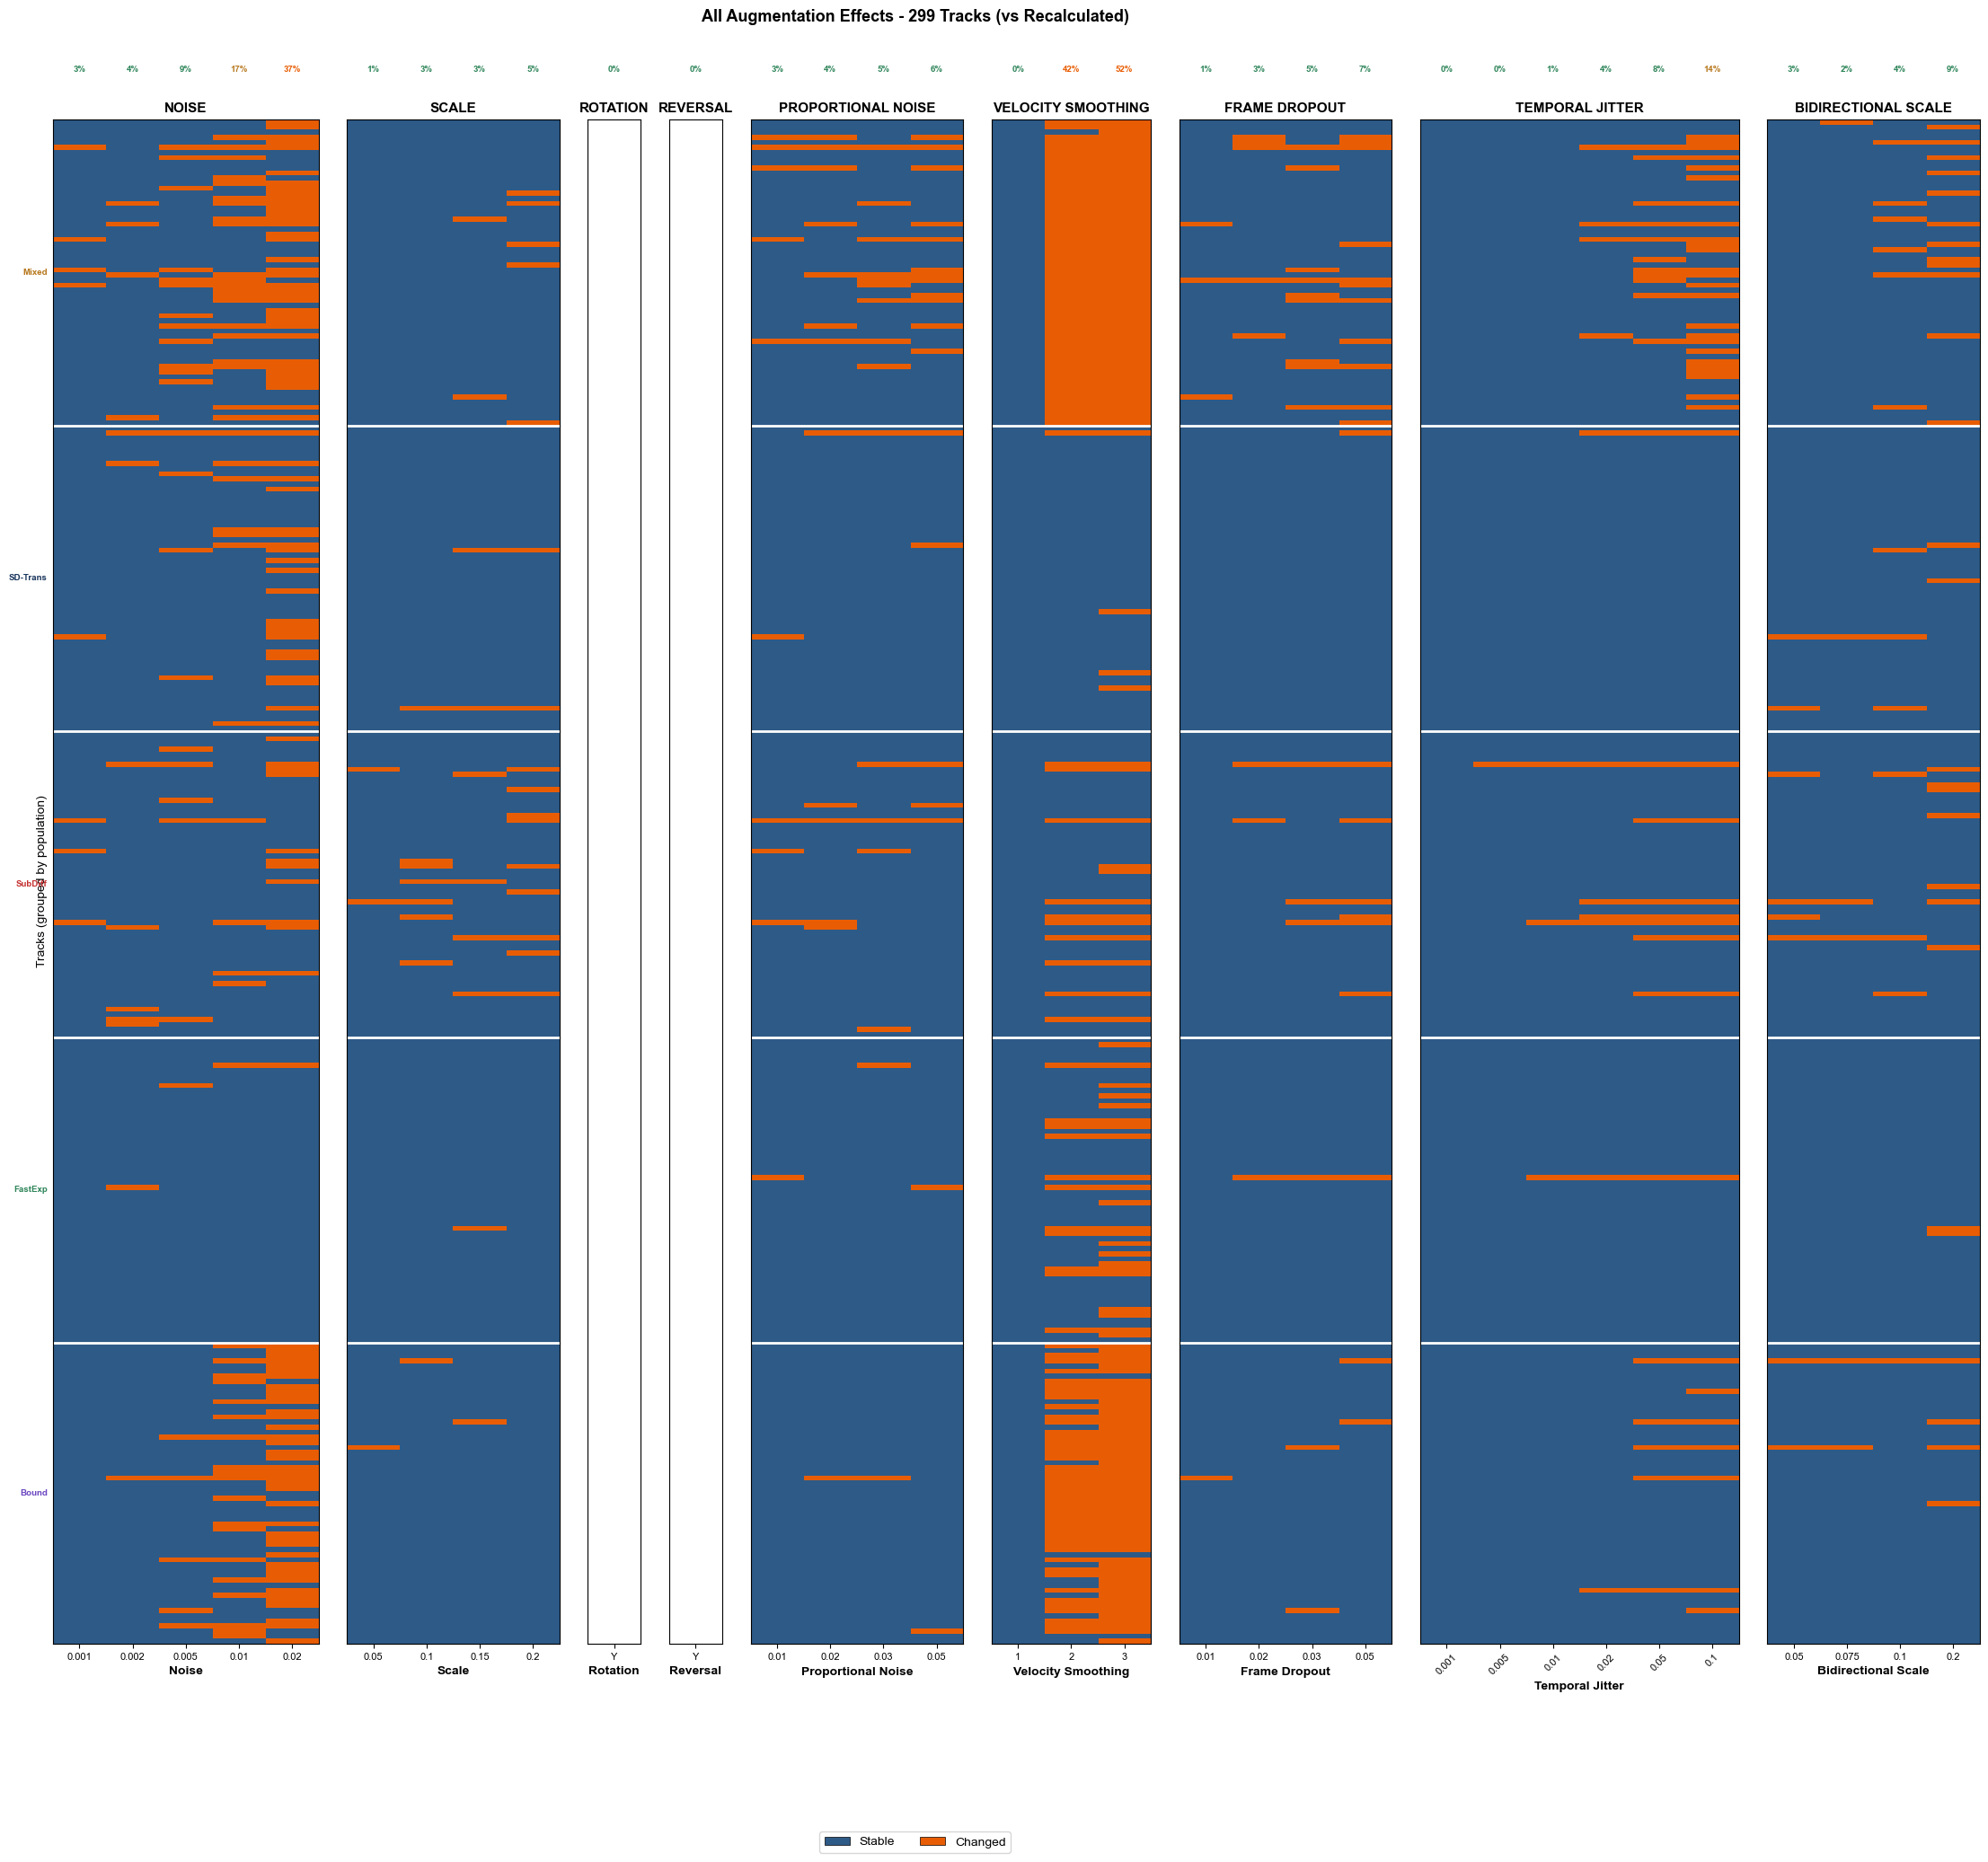


MULTI-AUGMENTATION STABILITY SUMMARY (299 tracks)

Mixed Exploratory Bound (60 tracks):
   Noise: 0.001(✓:7%) 0.002(✓:7%) 0.005(!:20%) 0.01(✗:35%) 0.02(✗:62%)  → max safe: 0.002
   Scale: 0.05(✓:0%) 0.1(✓:0%) 0.15(✓:3%) 0.2(✓:8%)  → max safe: 0.2
   Rotation: Y(✗:nan%)  → max safe: none
   Reversal: Y(✗:nan%)  → max safe: none
   Proportional_noise: 0.01(✓:8%) 0.02(!:12%) 0.03(!:15%) 0.05(!:20%)  → max safe: 0.01
   Velocity_smoothing: 1(✓:0%) 2(✗:98%) 3(✗:100%)  → max safe: 1
   Frame_dropout: 0.01(✓:5%) 0.02(✓:8%) 0.03(!:15%) 0.05(!:18%)  → max safe: 0.02
   Temporal_jitter: 0.001(✓:0%) 0.005(✓:0%) 0.01(✓:0%) 0.02(✓:7%) 0.05(!:18%) 0.1(✗:42%)  → max safe: 0.02
   Bidirectional_scale: 0.05(✓:0%) 0.075(✓:2%) 0.1(!:10%) 0.2(!:20%)  → max safe: 0.075

Superdiffusive Transport (60 tracks):
   Noise: 0.001(✓:2%) 0.002(✓:3%) 0.005(✓:7%) 0.01(!:12%) 0.02(✗:35%)  → max safe: 0.005
   Scale: 0.05(✓:0%) 0.1(✓:2%) 0.15(✓:3%) 0.2(✓:3%)  → max safe: 0.2
   Rotation: Y(✗:nan%)  → max safe: none
  

D:\GITHUB_SOFTWARE\SPTnano\src\SPTnano\visualization.py:17676: RuntimeWarning: Mean of empty slice
  overall_pct = [np.nanmean(data[:, j]) * 100 for j in range(len(levels))]


In [23]:
# =============================================================================
# PHASE 2, STEP 9: STACKED HEATMAP FOR ALL AUGMENTATION TYPES
# =============================================================================
# KEY: Uses RECALCULATED baseline for apples-to-apples comparison!
# NOW INCLUDES: ALL enabled augmentation types from AUGMENTATION_CONFIG

from SPTnano.visualization import plot_multi_augmentation_stability_heatmap

print("=" * 70)
print("PHASE 2, STEP 9: MULTI-AUGMENTATION EFFECT HEATMAP")
print("=" * 70)

# --- CONFIGURATION ---
USE_RECALCULATED_BASELINE = True  # True = apples-to-apples comparison
COLOR_BY_POPULATION = False       # True = color by resulting population, False = stable/changed

baseline_name = "recalculated" if USE_RECALCULATED_BASELINE else "original"
color_mode = "population" if COLOR_BY_POPULATION else "stable_changed"

n_total = sum(len(v) for v in selected_parents.values())
n_aug_types = sum(1 for cfg in AUGMENTATION_CONFIG.values() if cfg.get('enabled', True))

print(f"\n📊 Creating heatmap for {n_total:,} parent tracks...")
print(f"   Augmentation types: {n_aug_types} enabled")
print(f"   Comparing augmented tracks vs: {baseline_name} baseline")
print(f"   Color mode: {color_mode}")

# Show which augmentation types are enabled
print(f"\n   Enabled augmentations:")
for aug_type, aug_cfg in AUGMENTATION_CONFIG.items():
    if aug_cfg.get('enabled', True):
        levels = aug_cfg['levels']
        print(f"     • {aug_type}: {len(levels)} levels {levels}")

results = plot_multi_augmentation_stability_heatmap(
    classified_df=classified_df,
    selected_window_uids=selected_parents,
    augmentation_config=AUGMENTATION_CONFIG,
    tracks_per_pop=None,
    save_path=OUTPUT_FOLDER / f"stability_heatmap_ALL_AUGS_vs_{baseline_name}_{color_mode}.svg",
    show_pct_labels=True,
    title=f"All Augmentation Effects - {n_total:,} Tracks (vs {baseline_name.title()})",
    highlight_uids=all_small_uids,
    use_recalculated_baseline=USE_RECALCULATED_BASELINE,
    color_by_population=COLOR_BY_POPULATION,
)

print("\n✅ Multi-augmentation heatmap created!")
if COLOR_BY_POPULATION:
    print(f"""
INTERPRETATION (color = resulting population):
  - Purple = Bound | Blue = SuperDiff | Red = SubDiff
  - Gold = Mixed | Green = FastExp
  - Each cell shows WHERE the track ended up after augmentation
  - Compare starting pop (y-axis label) vs resulting pop (cell color)
""")
else:
    print(f"""
INTERPRETATION (comparing vs {baseline_name}):
  - Blue = augmented track stayed in same population (STABLE)
  - Orange = augmented track changed population (CHANGED)
  - White lines = boundaries between behavior types
  - X-axis = actual augmentation strength values
  
KEY INSIGHT:
  - Using recalculated baseline shows TRUE augmentation effect
  - Calculation differences are REMOVED from this comparison
  - Each column group represents a different augmentation type
  
RECOMMENDATIONS:
  - Use augmentation levels where <10% of children change
  - Check per-population thresholds in the summary above
  - Compare stability across different augmentation types
""")

Testing 9 augmentation types: ['temporal_jitter', 'noise', 'velocity_smoothing', 'proportional_noise', 'frame_dropout', 'bidirectional_scale', 'rotation', 'scale', 'reversal']

Testing: temporal_jitter
Levels: [0.001, 0.005, 0.01, 0.02, 0.05, 0.1]
💾 Saved: D:\TRANSFORMER_DEVELOPMENT\plots\augmentation_analysis\track_panel_temporal_jitter.svg


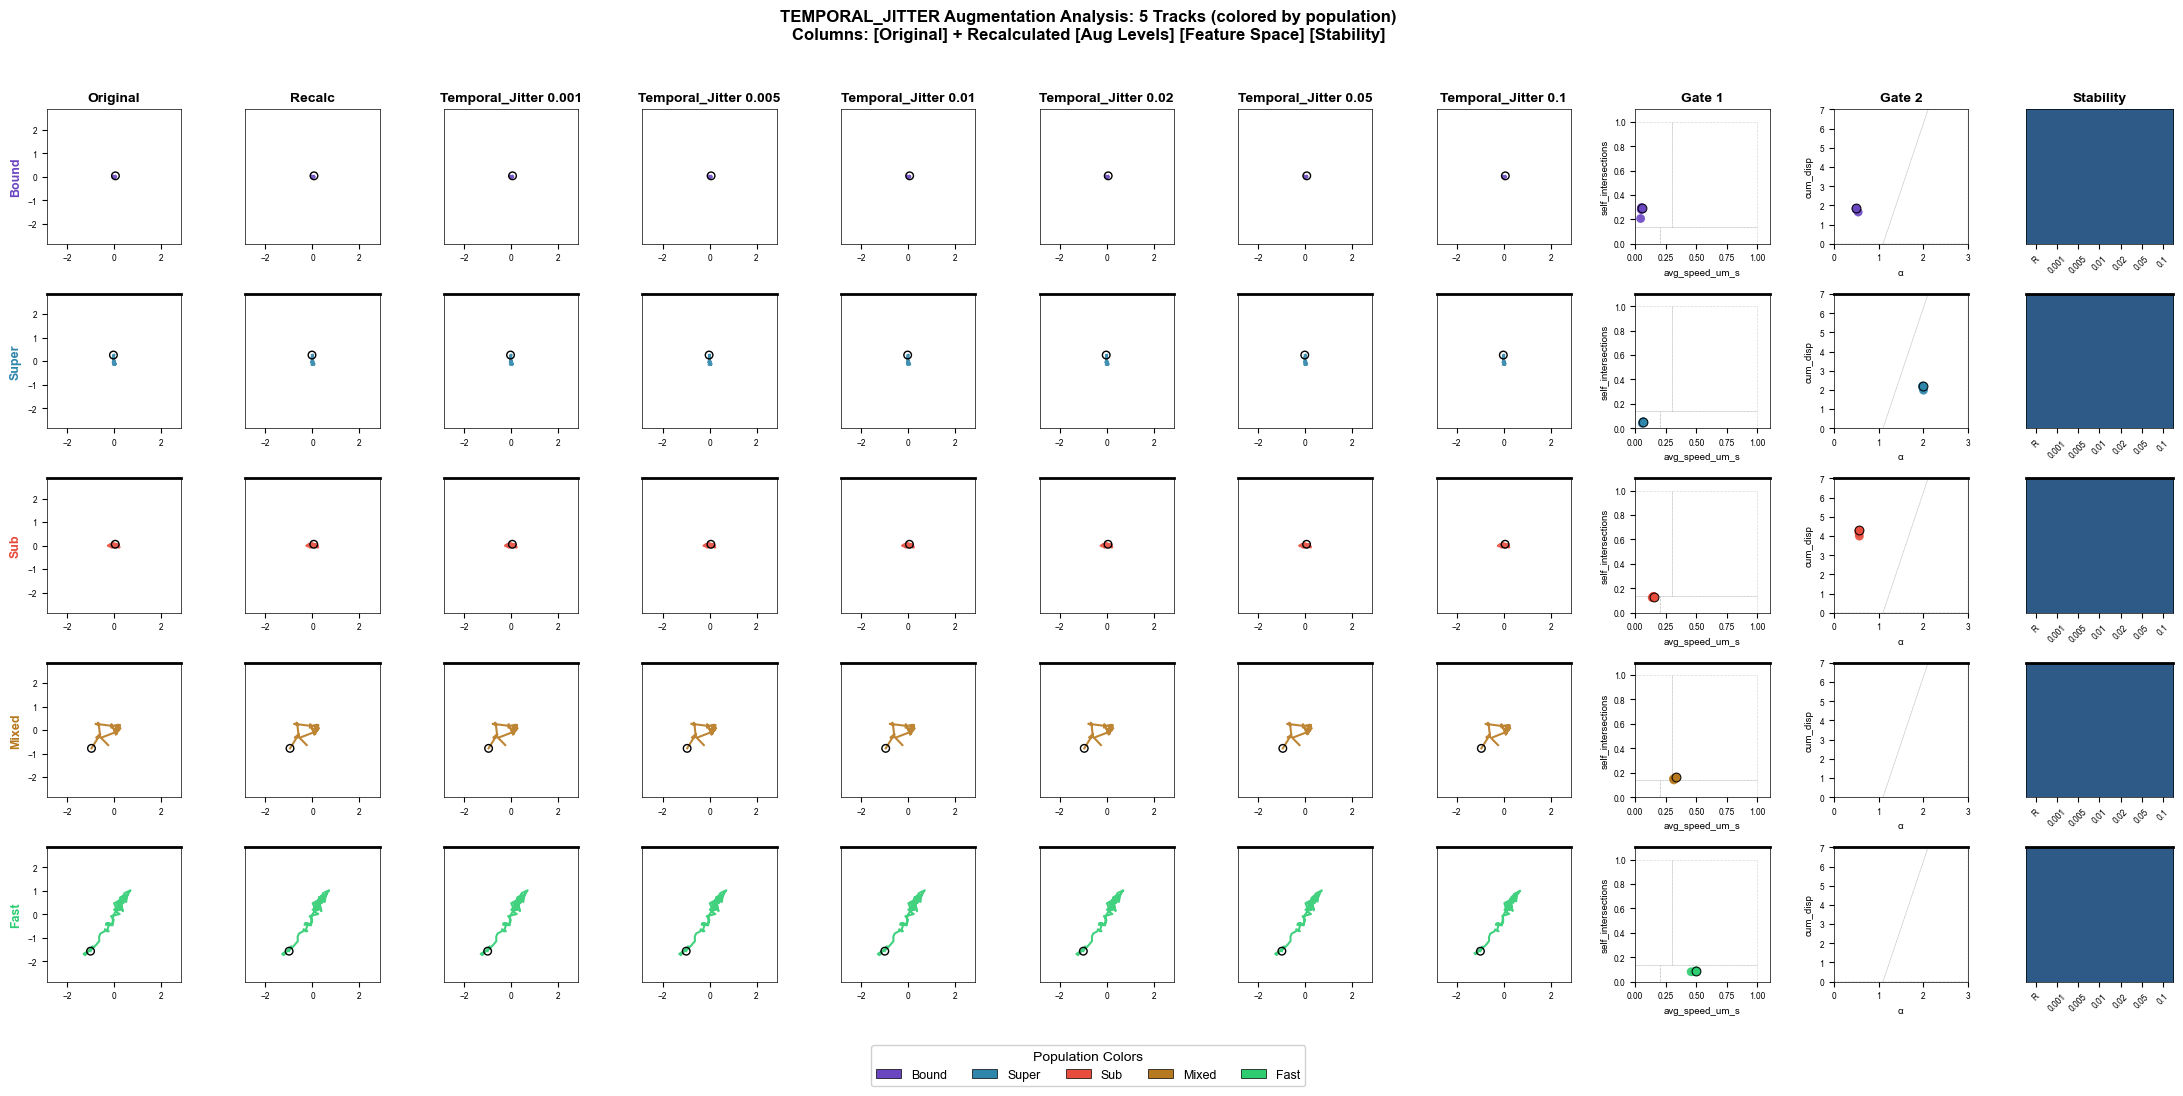

✅ Panel saved!

Testing: noise
Levels: [0.001, 0.002, 0.005, 0.01, 0.02]
💾 Saved: D:\TRANSFORMER_DEVELOPMENT\plots\augmentation_analysis\track_panel_noise.svg


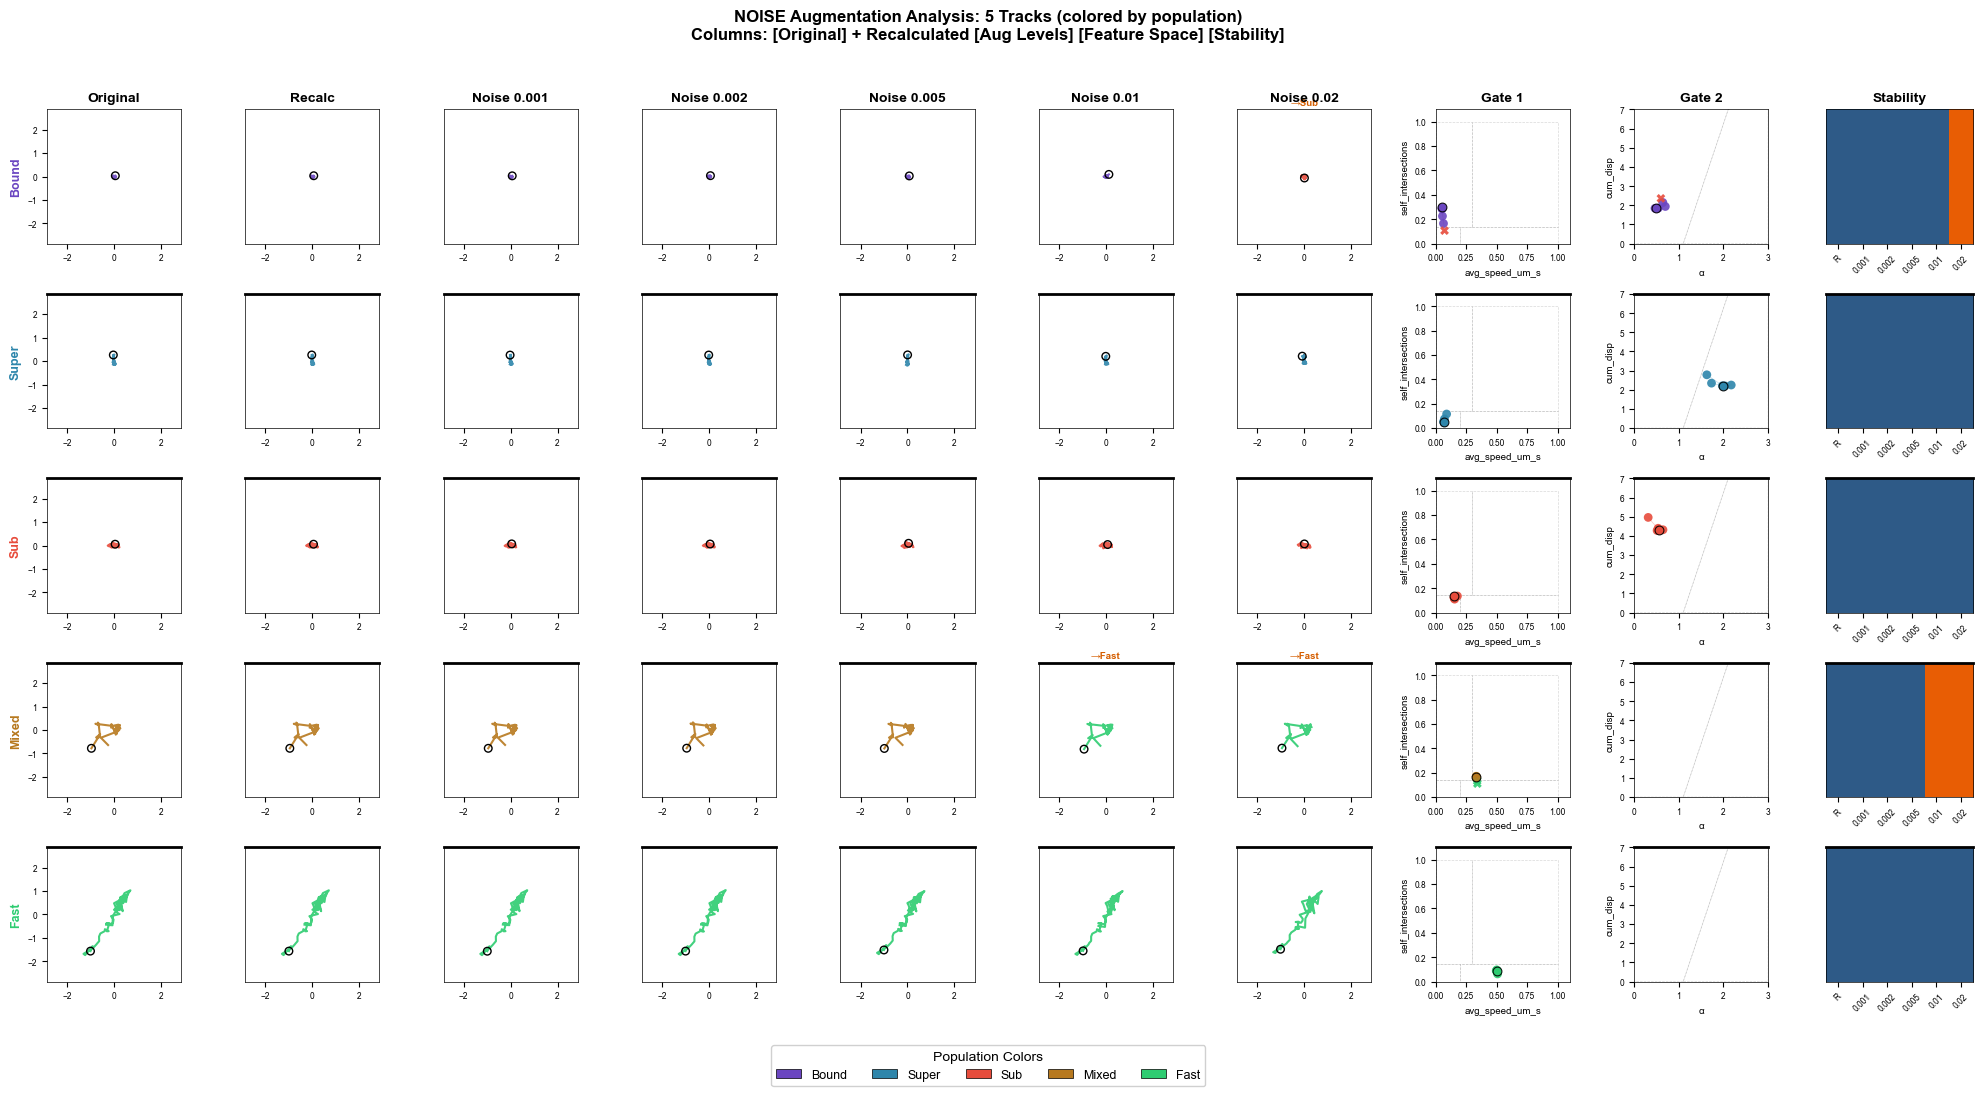

✅ Panel saved!

Testing: velocity_smoothing
Levels: [1, 2, 3]
💾 Saved: D:\TRANSFORMER_DEVELOPMENT\plots\augmentation_analysis\track_panel_velocity_smoothing.svg


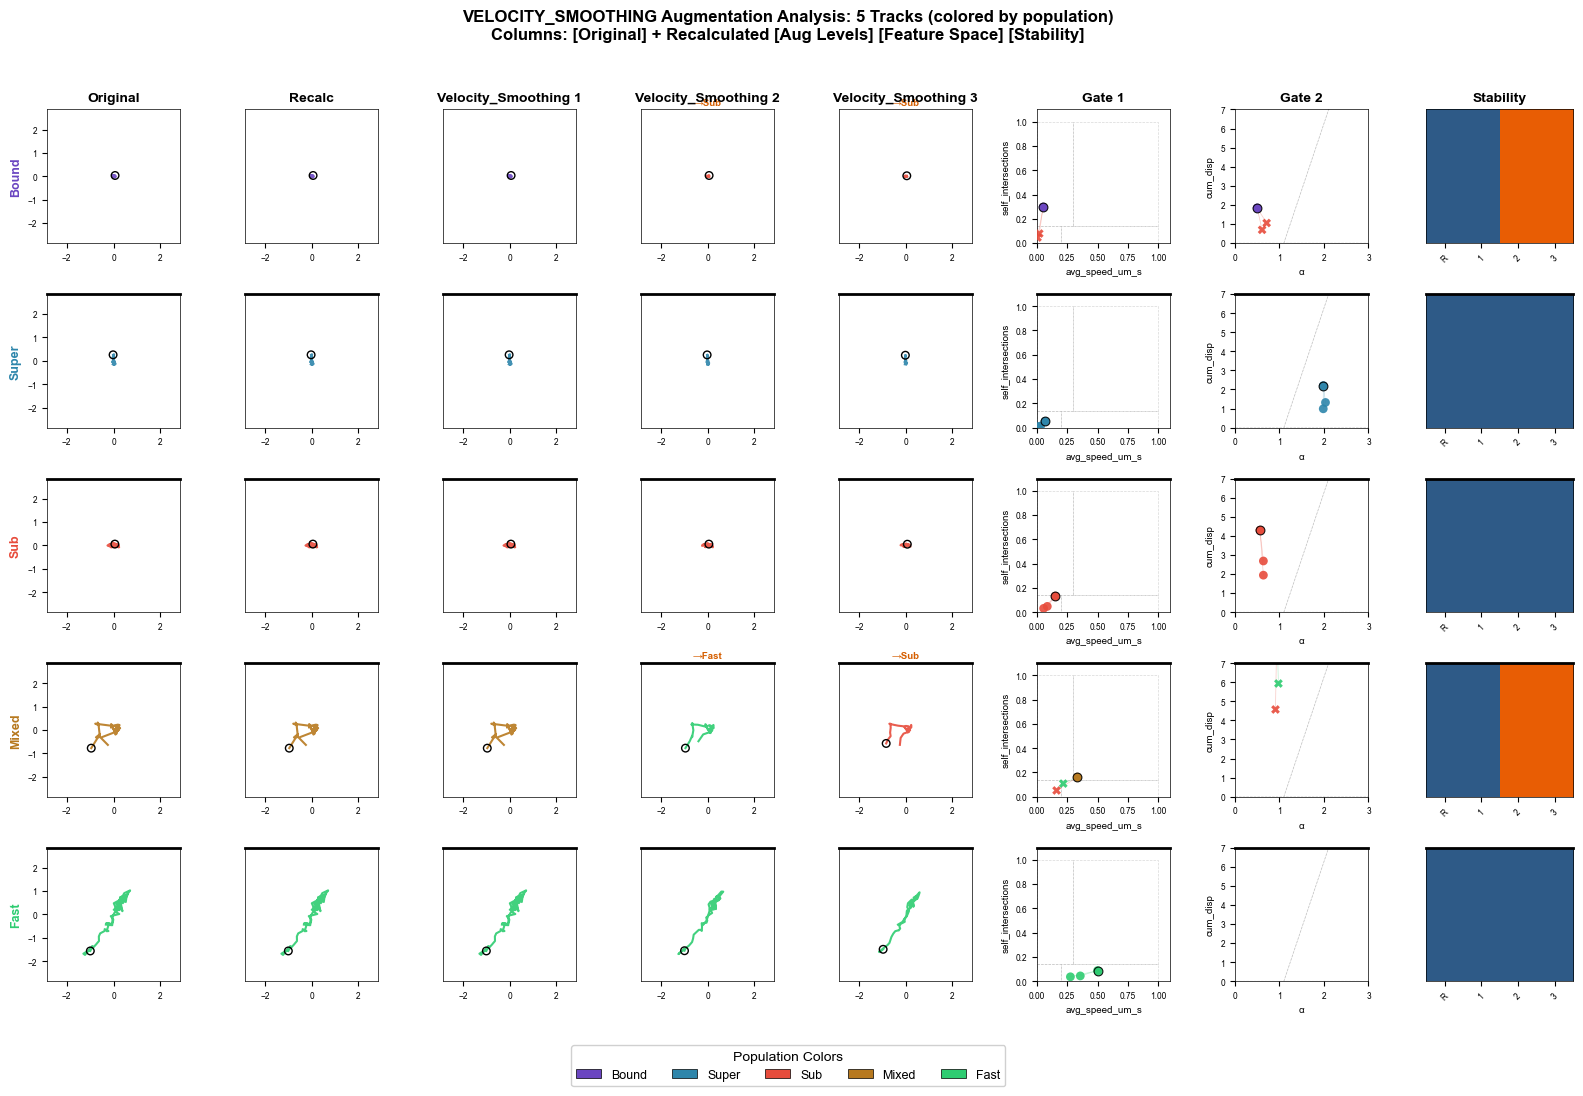

✅ Panel saved!

Testing: proportional_noise
Levels: [0.01, 0.02, 0.03, 0.05]
💾 Saved: D:\TRANSFORMER_DEVELOPMENT\plots\augmentation_analysis\track_panel_proportional_noise.svg


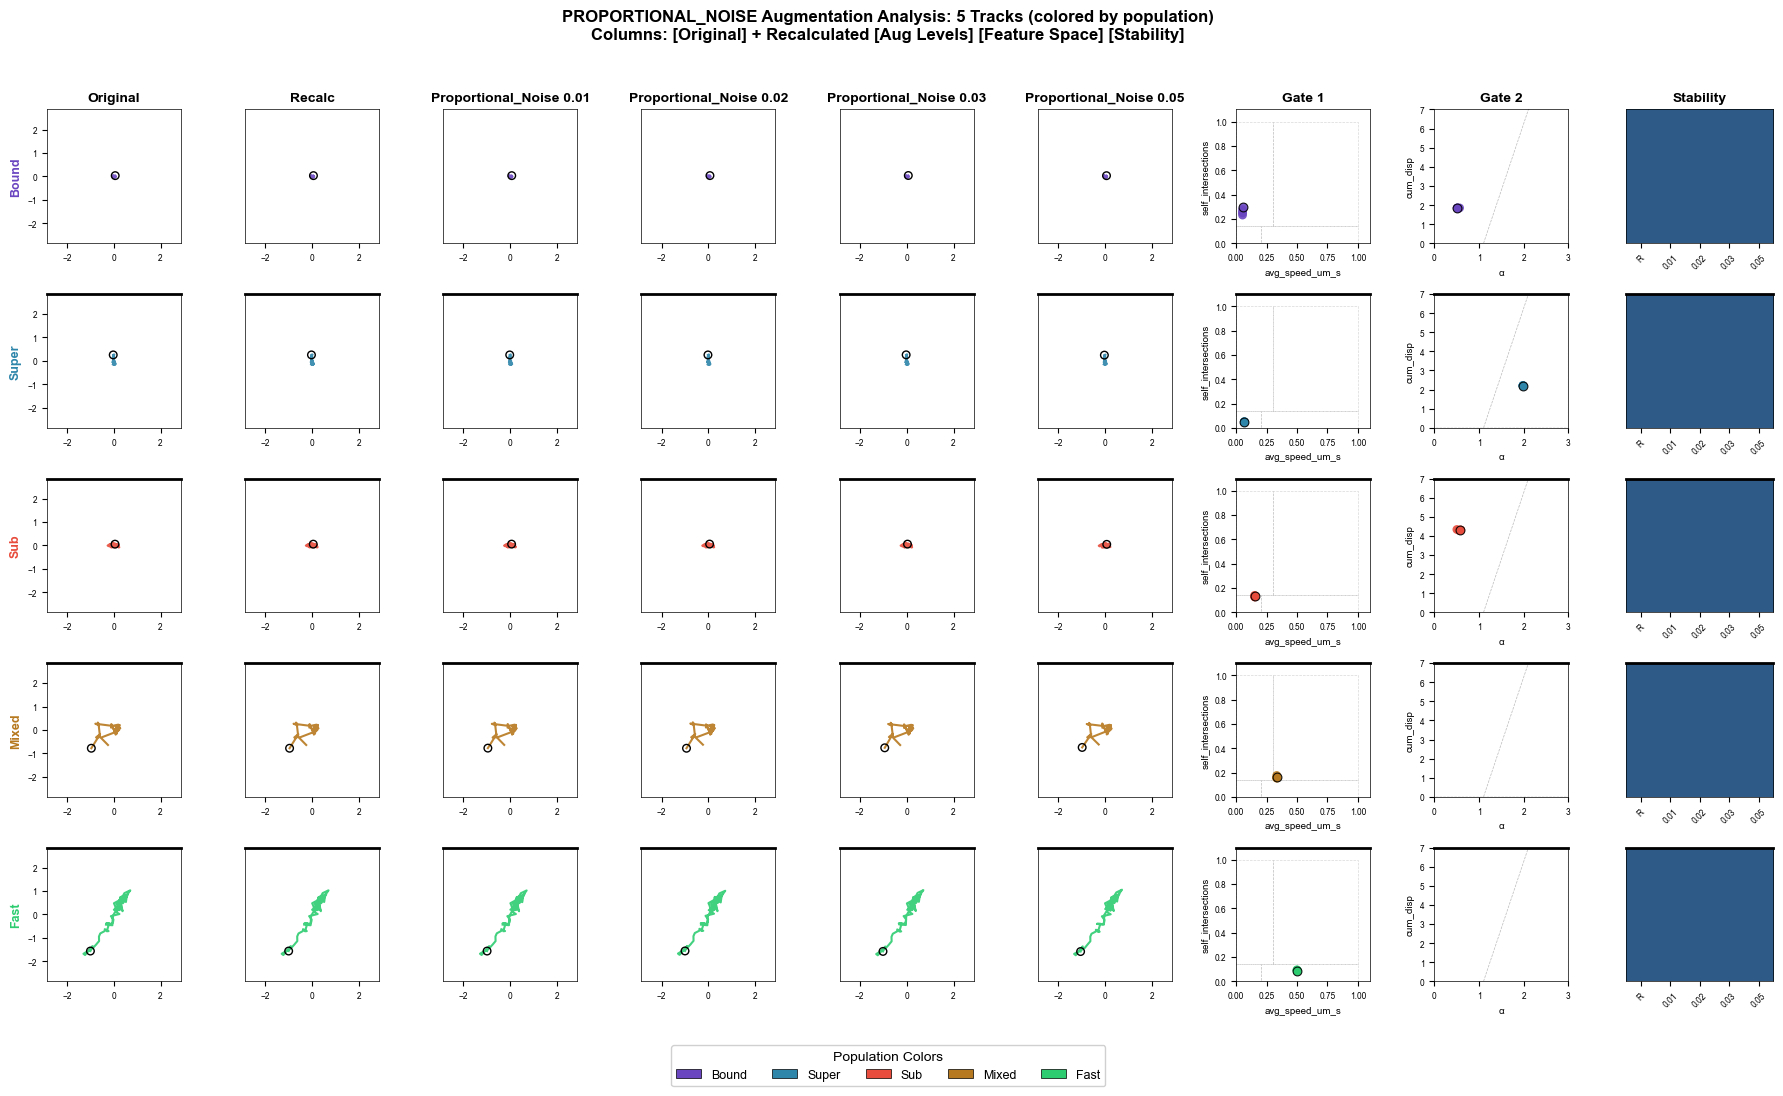

✅ Panel saved!

Testing: frame_dropout
Levels: [0.01, 0.02, 0.03, 0.05]
💾 Saved: D:\TRANSFORMER_DEVELOPMENT\plots\augmentation_analysis\track_panel_frame_dropout.svg


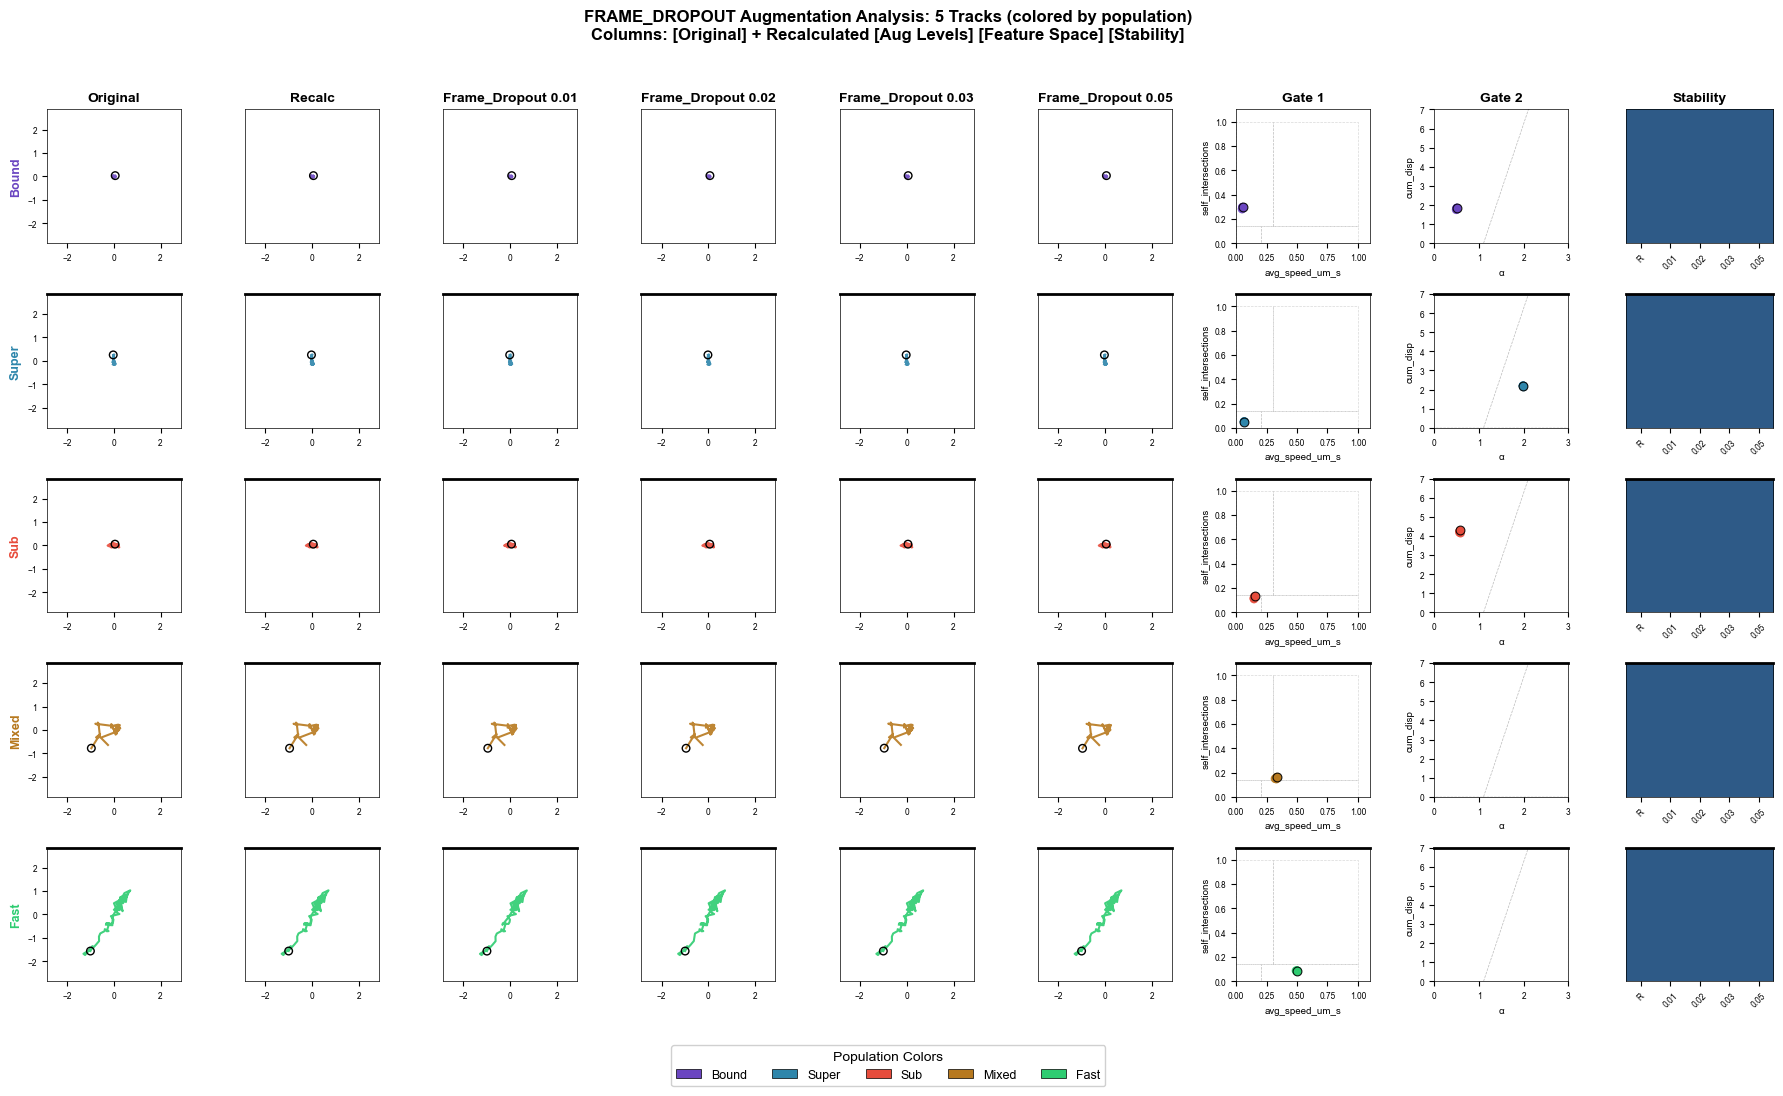

✅ Panel saved!

Testing: bidirectional_scale
Levels: [0.05, 0.075, 0.1, 0.2]
💾 Saved: D:\TRANSFORMER_DEVELOPMENT\plots\augmentation_analysis\track_panel_bidirectional_scale.svg


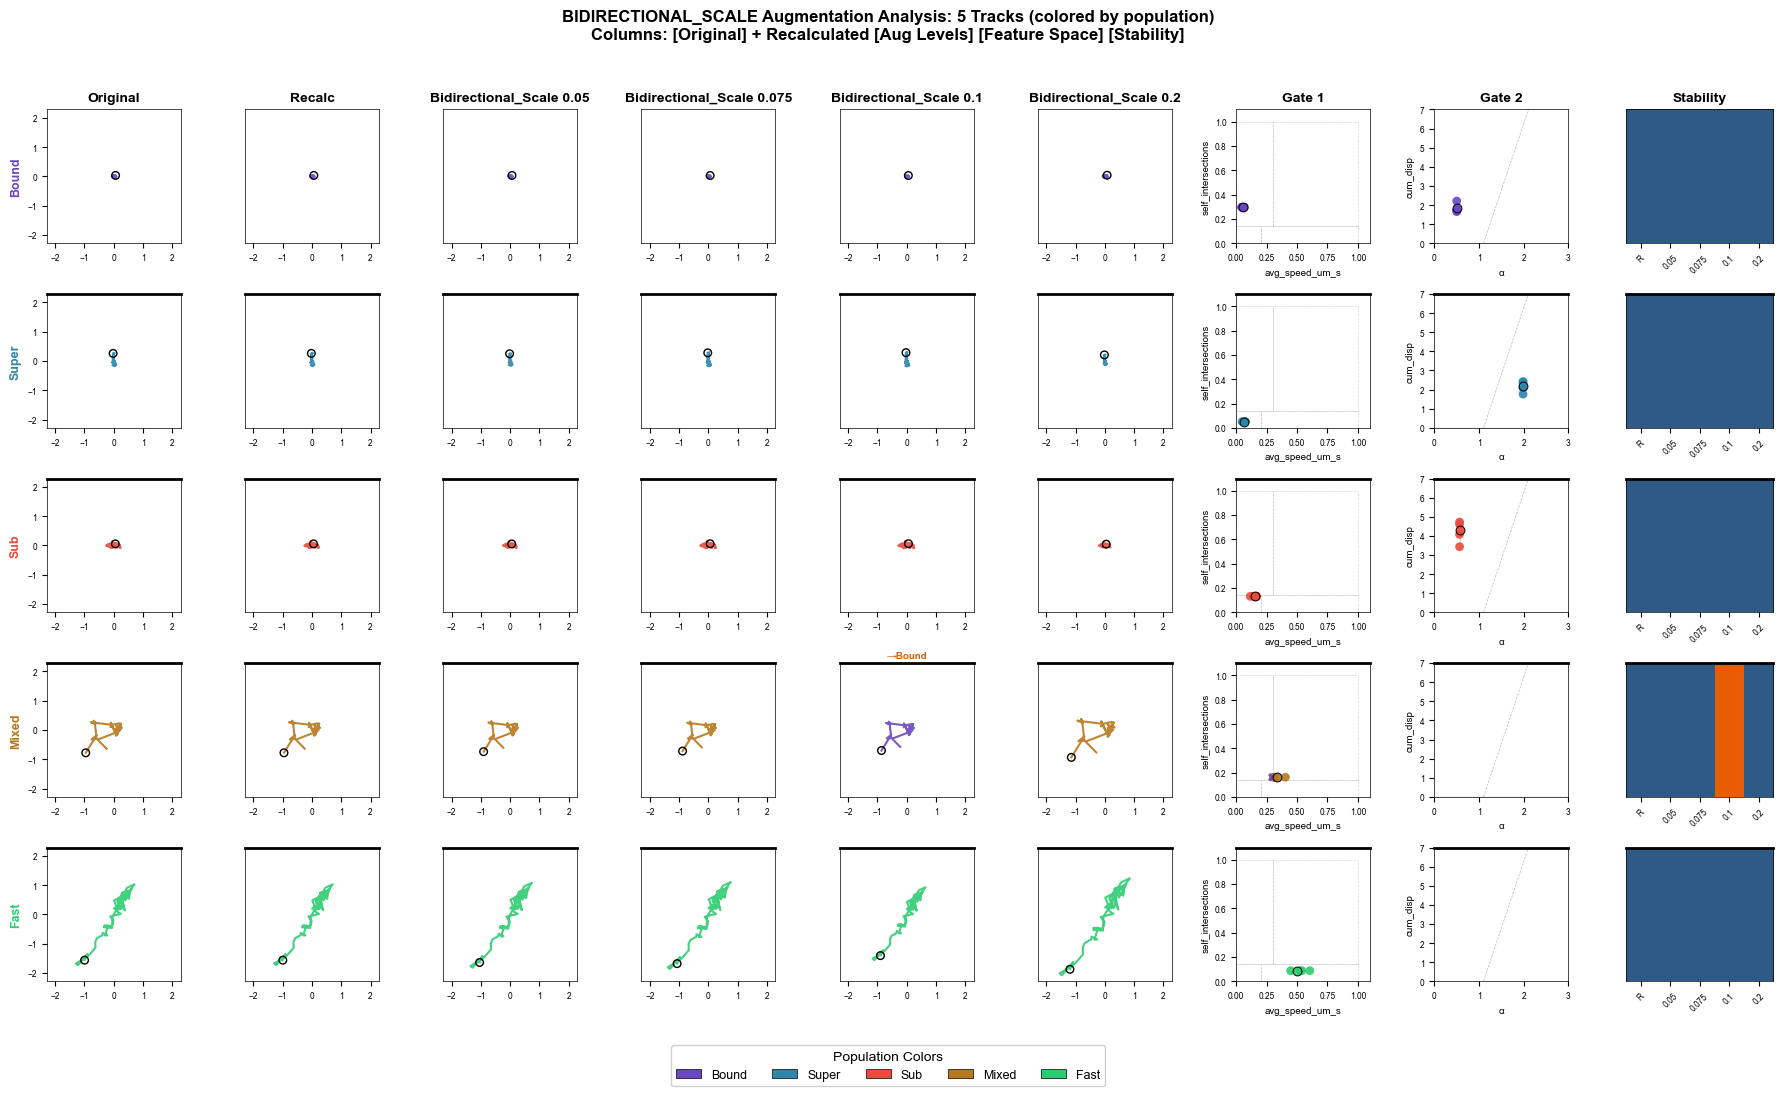

✅ Panel saved!

Testing: rotation
Levels: [True]
💾 Saved: D:\TRANSFORMER_DEVELOPMENT\plots\augmentation_analysis\track_panel_rotation.svg


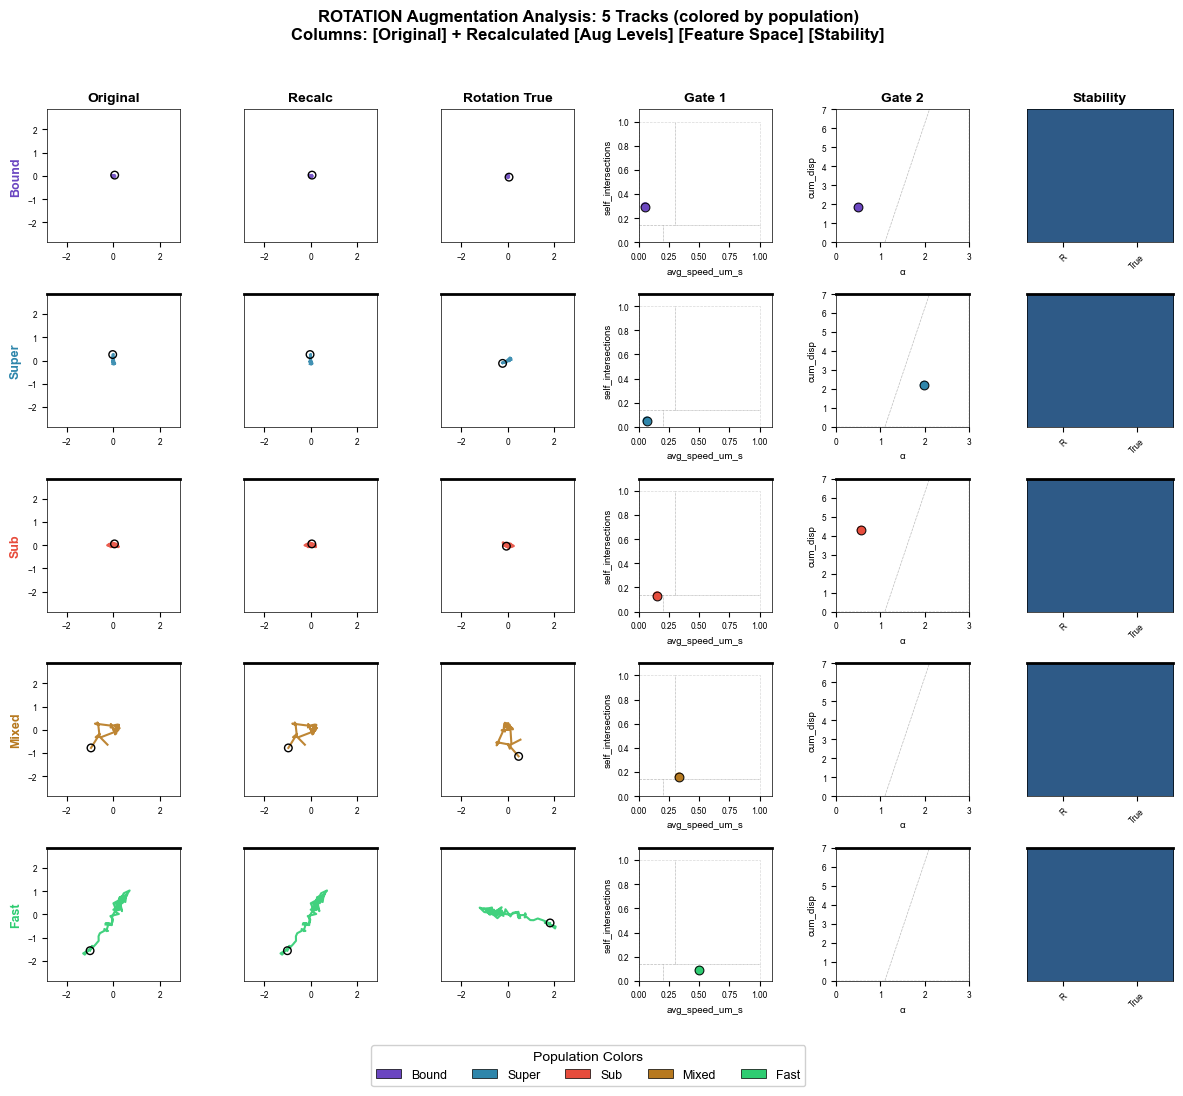

✅ Panel saved!

Testing: scale
Levels: [0.05, 0.1, 0.15, 0.2]
💾 Saved: D:\TRANSFORMER_DEVELOPMENT\plots\augmentation_analysis\track_panel_scale.svg


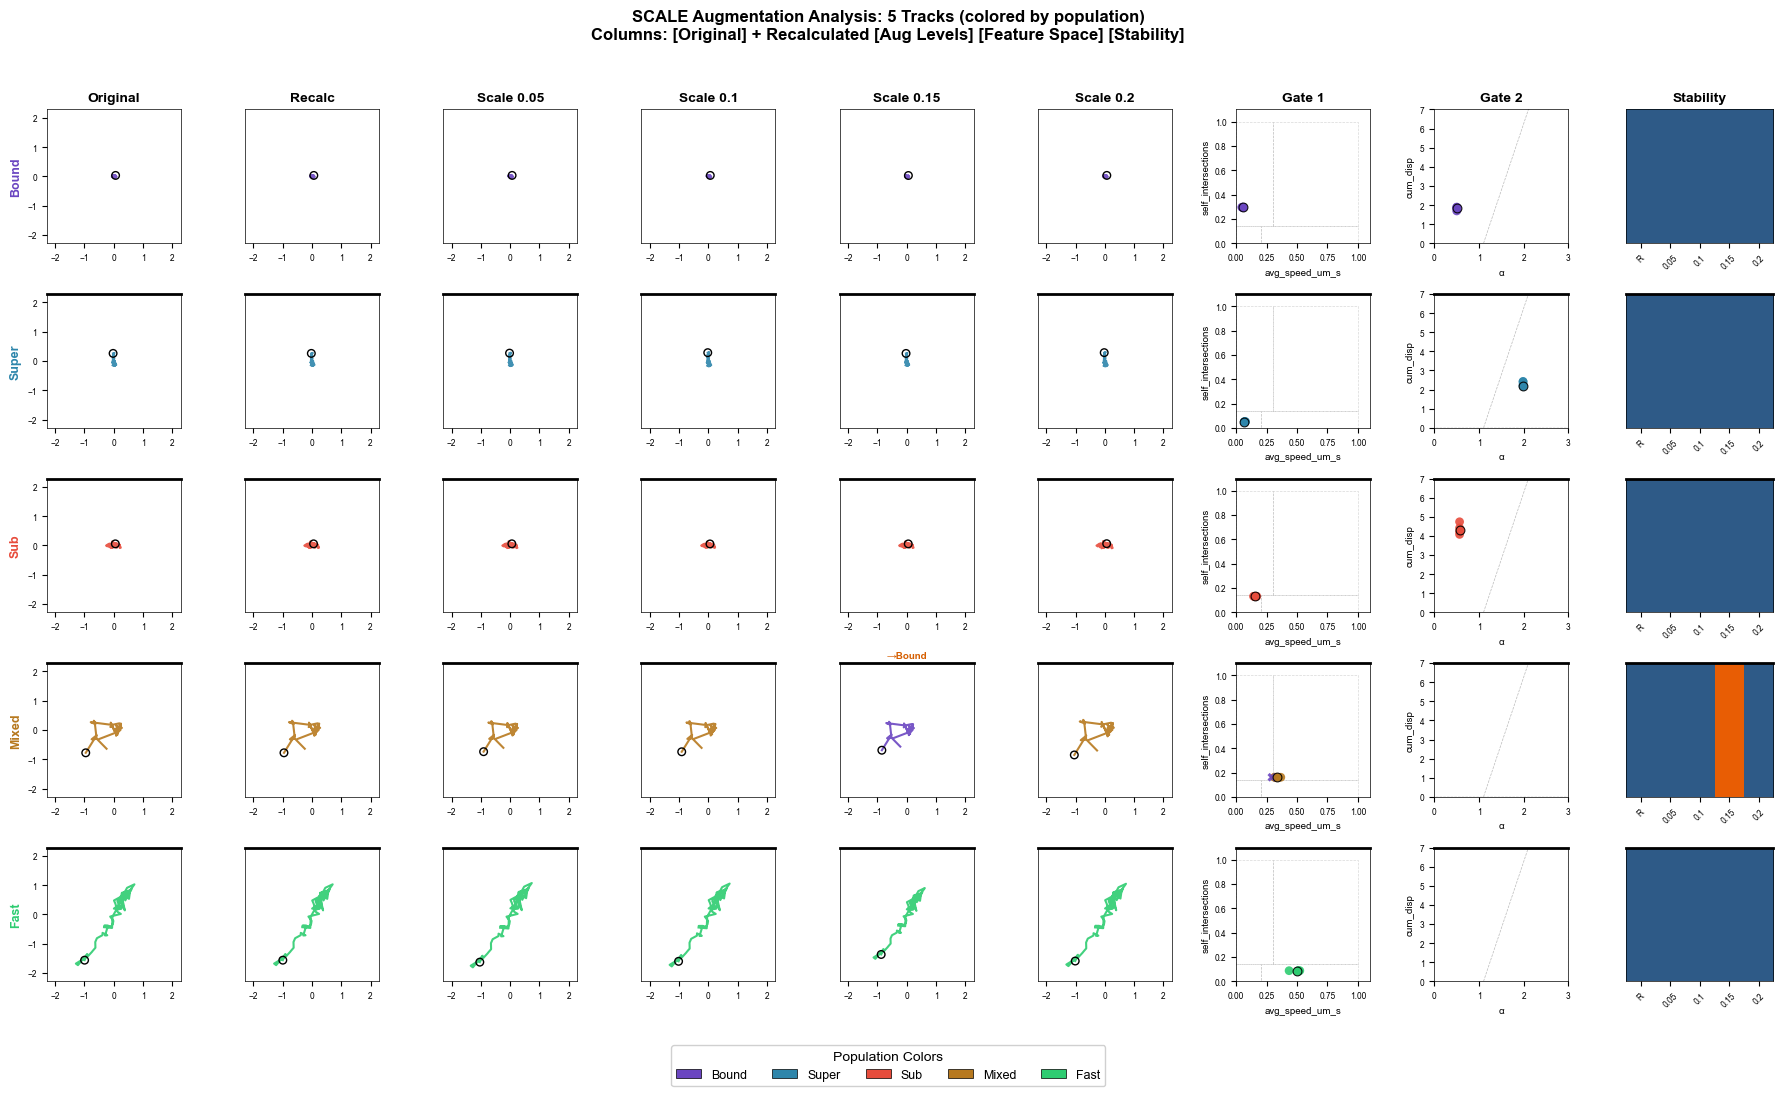

✅ Panel saved!

Testing: reversal
Levels: [True]
💾 Saved: D:\TRANSFORMER_DEVELOPMENT\plots\augmentation_analysis\track_panel_reversal.svg


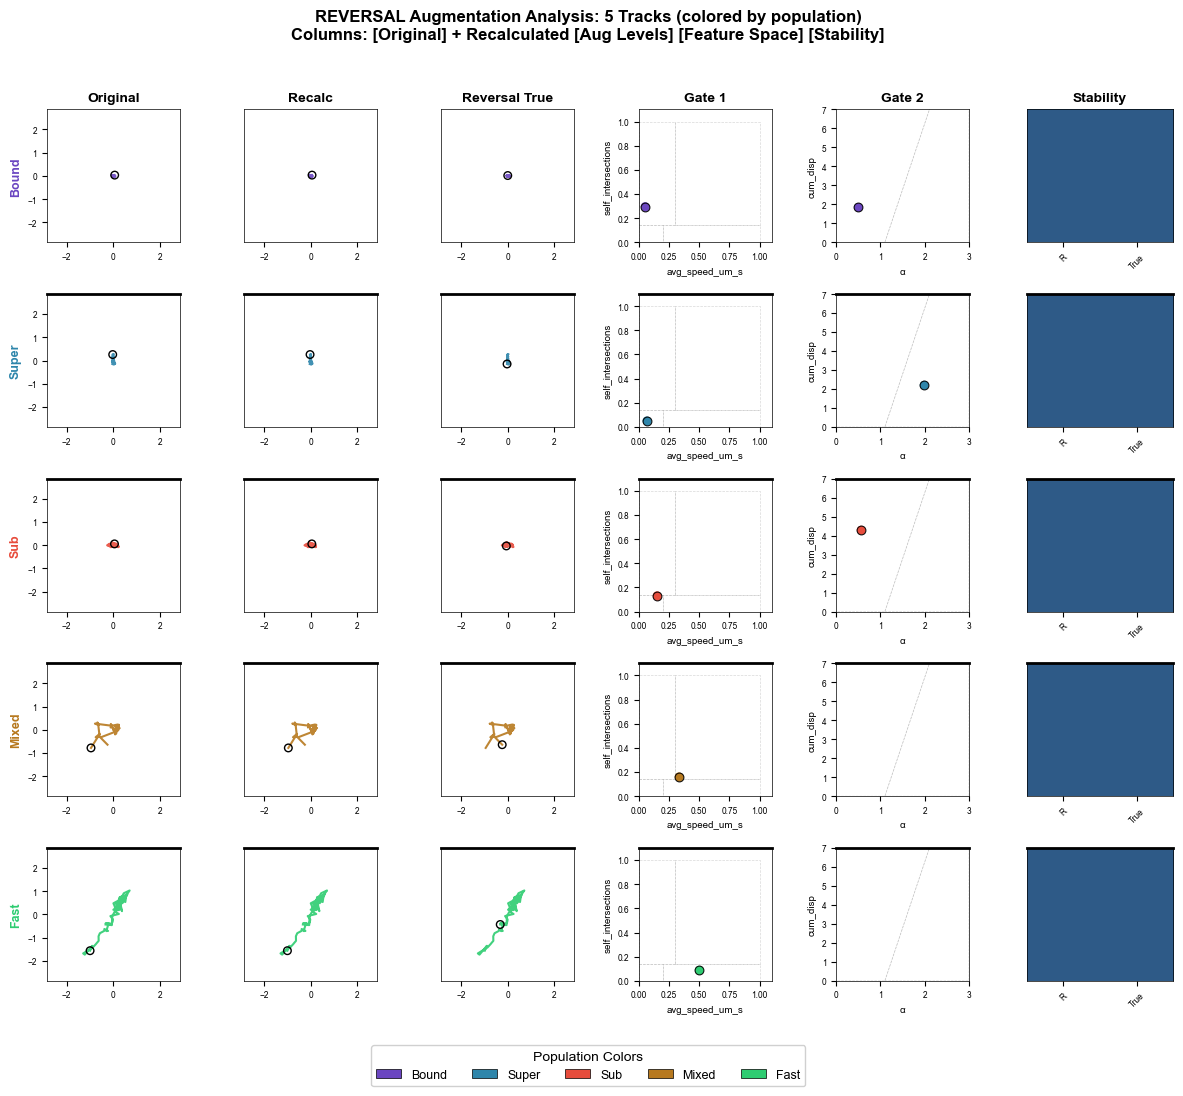

✅ Panel saved!


In [24]:
# Get all track types in the data, then filter to only ACTUAL augmentation types
test_track_types = classified_df['track_type'].unique().to_list()
aug_types_to_test = [t for t in test_track_types if t in AUGMENTATION_CONFIG]
print(f"Testing {len(aug_types_to_test)} augmentation types: {aug_types_to_test}")

N_SAMPLE = 1  # Set to 1 for interleaved layout (1 per behavior)

# Gate 2 polygon boundaries (defined once outside loop)
GATE2_BOUNDS = {
    'superdiffusive': [(1.1, 0.0), (2.25, 8.0), (3.0, 8.0), (3.0, 0.0)],
    'subdiffusive': [(-0.5, 0.0), (-0.5, 8.0), (2.25, 8.0), (1.1, 0.0)],
}

for TEST_AUG_TYPE in aug_types_to_test:
    TEST_AUG_LEVELS = AUGMENTATION_CONFIG[TEST_AUG_TYPE]['levels']
    print(f"\n{'='*60}")
    print(f"Testing: {TEST_AUG_TYPE}")
    print(f"Levels: {TEST_AUG_LEVELS}")
    
    # Sample tracks
    test_tracks = {}
    for pop in small_selection.keys():
        uids = list(small_selection[pop])[:N_SAMPLE]
        test_tracks[pop] = uids
    
    from SPTnano.visualization import plot_tracks_augmentation_panel
    
    fig = plot_tracks_augmentation_panel(
        window_uids=test_tracks,
        instant_df=instant_df,
        classified_df=classified_df,
        aug_type=TEST_AUG_TYPE,
        aug_levels=TEST_AUG_LEVELS,
        # Gate 1 settings
        x_col='avg_speed_um_s',
        y_col='self_intersections',
        scaler=scaler_gate1,
        gate_bounds=GATE1_BOUNDS,
        # Gate 2 settings
        show_gate2=True,
        x_col_gate2='anomalous_exponent',
        y_col_gate2='cum_displacement_um',
        scaler_gate2=None,
        gate_bounds_gate2=GATE2_BOUNDS,
        gate2_populations=['superdiffusive_transport', 'subdiffusive_motion'],
        # Layout: INTERLEAVED (bound, super, sub, mixed, fast, repeat)
        interleave_populations=True,
        tracks_per_population=N_SAMPLE,  # 1 = one track per behavior type per row-group
        # General settings
        figsize_per_cell=(2.0, 2.0),
        population_order=['bound_stationary', 'superdiffusive_transport', 'subdiffusive_motion', 
                        'mixed_exploratory_bound', 'fast_exploratory'],
        show_boundaries=True,
        color_by_population=True,
        show_recalculated=True,
        save_path=OUTPUT_FOLDER / f"track_panel_{TEST_AUG_TYPE}.svg",
    )
    
    print(f"✅ Panel saved!")

GATE 1 & 2: SINGLE COMBINED PANEL

📊 Creating 7 × 9 combined panel:
   Gate 1: 5 rows (all 5 populations)
   Gate 2: 2 rows (SuperDiff, SubDiff)
   Columns: 9 augmentation types

💾 Saved: D:\TRANSFORMER_DEVELOPMENT\plots\augmentation_analysis\gate1_gate2_combined_panel.svg


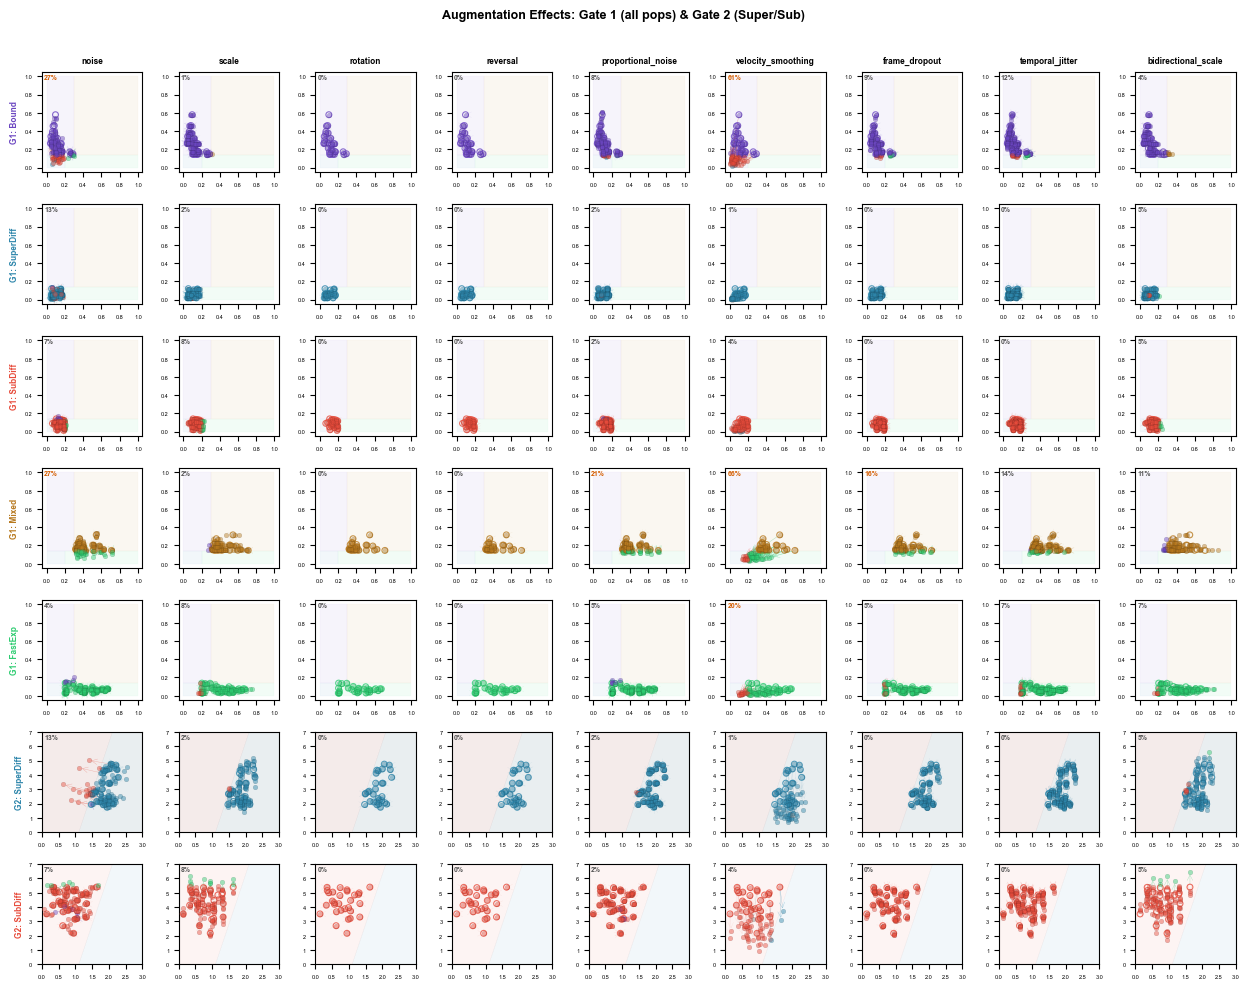


📊 COLOR KEY
Dot/Arrow color = POPULATION of track:
  ● Bound: #6B46C1
  ● SuperDiff: #2E86AB
  ● SubDiff: #E74C3C
  ● Mixed: #B7791F
  ● FastExp: #2ECC71

○ Hollow = Recalculated baseline | ● Filled = Augmented
% = fraction of tracks that CHANGED population
Orange % = >15% changed (caution)


In [25]:
# =============================================================================
# GATE 1 & 2: SINGLE COMBINED PANEL (ALL POPULATIONS)
# =============================================================================
# One comprehensive figure showing Gate 1 (5 rows) + Gate 2 (2 rows)
# Columns = augmentation types, dots colored by resulting population

from matplotlib.patches import Polygon

print("=" * 70)
print("GATE 1 & 2: SINGLE COMBINED PANEL")
print("=" * 70)

# --- CONFIGURATION ---
N_TRACKS_V2 = 30         # Tracks per population

enabled_augs_v2 = get_enabled_augmentations()
AUG_TYPES_V2 = list(enabled_augs_v2.keys())
n_aug_v2 = len(AUG_TYPES_V2)

# POPULATION COLORS
POP_COLORS = {
    'bound_stationary': '#6B46C1',           # Purple
    'superdiffusive_transport': '#2E86AB',   # Blue  
    'subdiffusive_motion': '#E74C3C',        # Red
    'mixed_exploratory_bound': '#B7791F',    # Gold/Brown
    'fast_exploratory': '#2ECC71',           # Green
    'ungatedgate1': '#888888',
    'ungatedgate2': '#888888',
}

GATE1_RECTS_V2 = {
    'low_speed_low_intersections': {'x': (0.0, 0.2), 'y': (0.0, 0.14), 'color': '#2E86AB'},
    'high_speed_low_intersections': {'x': (0.2, 1.0), 'y': (0.0, 0.14), 'color': '#2ECC71'},
    'low_speed_high_intersections': {'x': (0.0, 0.3), 'y': (0.14, 1.0), 'color': '#6B46C1'},
    'high_speed_high_intersections': {'x': (0.3, 1.0), 'y': (0.14, 1.0), 'color': '#B7791F'},
}

GATE2_SUPER_V2 = [(1.1, 0.0), (2.25, 8.0), (3.0, 8.0), (3.0, 0.0)]
GATE2_SUB_V2 = [(-0.5, 0.0), (-0.5, 8.0), (2.25, 8.0), (1.1, 0.0)]

POPS_V2 = ['bound_stationary', 'superdiffusive_transport', 'subdiffusive_motion', 
           'mixed_exploratory_bound', 'fast_exploratory']
GATE2_POPS_V2 = ['superdiffusive_transport', 'subdiffusive_motion']
POP_ABB_V2 = {'bound_stationary': 'Bound', 'superdiffusive_transport': 'SuperDiff',
              'subdiffusive_motion': 'SubDiff', 'mixed_exploratory_bound': 'Mixed', 
              'fast_exploratory': 'FastExp'}

def plot_by_population(ax, parent_uids, aug_type, gate_type='gate1'):
    """Plot ALL levels, colored by resulting POPULATION"""
    import warnings
    n_stable, n_changed = 0, 0
    all_levels = enabled_augs_v2[aug_type]['levels']
    
    for parent_uid in parent_uids:
        recalc = classified_df.filter(pl.col('window_uid') == f"{parent_uid}_recalculated")
        if recalc.height == 0: continue
        
        if gate_type == 'gate1':
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                recalc_sc = scaler_gate1.transform([[recalc['avg_speed_um_s'][0], recalc['self_intersections'][0]]])[0]
            rx, ry = recalc_sc[0], recalc_sc[1]
        else:
            rx, ry = recalc['anomalous_exponent'][0], recalc['cum_displacement_um'][0]
        
        recalc_pop = recalc['final_population'][0]
        recalc_color = POP_COLORS.get(recalc_pop, '#888888')
        
        ax.scatter(rx, ry, c='none', s=18, marker='o', zorder=4, 
                   edgecolor=recalc_color, linewidth=0.8, alpha=0.8)
        
        for level in all_levels:
            level_str = str(level) if not isinstance(level, bool) else 'applied'
            aug = classified_df.filter(pl.col('window_uid') == f"{parent_uid}_{aug_type}_{level_str}")
            if aug.height == 0: continue
            
            if gate_type == 'gate1':
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    aug_sc = scaler_gate1.transform([[aug['avg_speed_um_s'][0], aug['self_intersections'][0]]])[0]
                ax_v, ay_v = aug_sc[0], aug_sc[1]
            else:
                ax_v, ay_v = aug['anomalous_exponent'][0], aug['cum_displacement_um'][0]
            
            aug_pop = aug['final_population'][0]
            aug_color = POP_COLORS.get(aug_pop, '#888888')
            
            if aug_pop == recalc_pop:
                n_stable += 1
                arrow_alpha = 0.12
            else:
                n_changed += 1
                arrow_alpha = 0.45
            
            ax.scatter(ax_v, ay_v, c=aug_color, s=12, marker='o', zorder=5, 
                       edgecolor='black', linewidth=0.1, alpha=0.45)
            ax.annotate('', xy=(ax_v, ay_v), xytext=(rx, ry),
                        arrowprops=dict(arrowstyle='->', color=aug_color, lw=0.25, alpha=arrow_alpha))
    
    total = n_stable + n_changed
    return n_stable, n_changed, 100*n_changed/total if total > 0 else 0

# Build parent UIDs for each population
pop_parents_dict = {}
for pop in POPS_V2:
    pop_parents_dict[pop] = [u for u in all_parent_uids
                             if classified_df.filter(pl.col('window_uid')==f"{u}_recalculated").height>0 and
                             classified_df.filter(pl.col('window_uid')==f"{u}_recalculated")['final_population'][0]==pop][:N_TRACKS_V2]

# Grid: 5 rows (Gate 1 - all pops) + 2 rows (Gate 2 - Super/Sub) × n_aug columns
n_gate1_rows = len(POPS_V2)
n_gate2_rows = len(GATE2_POPS_V2)
n_rows = n_gate1_rows + n_gate2_rows
n_cols = n_aug_v2

print(f"\n📊 Creating {n_rows} × {n_cols} combined panel:")
print(f"   Gate 1: {n_gate1_rows} rows (all 5 populations)")
print(f"   Gate 2: {n_gate2_rows} rows (SuperDiff, SubDiff)")
print(f"   Columns: {n_cols} augmentation types")

# Create single figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(1.4*n_cols, 1.4*n_rows))

# --- Gate 1 rows (all 5 populations) ---
for row_idx, pop in enumerate(POPS_V2):
    pop_parents = pop_parents_dict[pop]
    for col_idx, aug_t in enumerate(AUG_TYPES_V2):
        ax = axes[row_idx, col_idx]
        
        # Draw gate regions
        for g, p in GATE1_RECTS_V2.items():
            ax.add_patch(plt.Rectangle((p['x'][0], p['y'][0]), p['x'][1]-p['x'][0], p['y'][1]-p['y'][0], 
                                       alpha=0.06, facecolor=p['color'], edgecolor=p['color'], lw=0.25))
        
        ns, nc, pct = plot_by_population(ax, pop_parents, aug_t, 'gate1')
        
        # Column titles (top row only)
        if row_idx == 0:
            ax.set_title(f"{aug_t}", fontsize=6, fontweight='bold')
        
        # Row labels (left column only)
        if col_idx == 0:
            ax.set_ylabel(f"G1: {POP_ABB_V2[pop]}", fontsize=6, fontweight='bold', 
                         color=POP_COLORS[pop])
        
        ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-0.05, 1.05)
        ax.set_aspect('equal')
        ax.tick_params(labelsize=4)
        ax.text(0.02, 0.98, f"{pct:.0f}%", transform=ax.transAxes, fontsize=5, va='top', fontweight='bold',
               color='#D55E00' if pct > 15 else '#555555')

# --- Gate 2 rows (SuperDiff and SubDiff) ---
for row_offset, pop in enumerate(GATE2_POPS_V2):
    row_idx = n_gate1_rows + row_offset
    pop_parents = pop_parents_dict[pop]
    
    for col_idx, aug_t in enumerate(AUG_TYPES_V2):
        ax = axes[row_idx, col_idx]
        
        # Draw gate regions
        ax.add_patch(Polygon(GATE2_SUPER_V2, alpha=0.06, facecolor='#2E86AB', edgecolor='#2E86AB', lw=0.25))
        ax.add_patch(Polygon(GATE2_SUB_V2, alpha=0.06, facecolor='#E74C3C', edgecolor='#E74C3C', lw=0.25))
        
        ns, nc, pct = plot_by_population(ax, pop_parents, aug_t, 'gate2')
        
        # Row labels (left column only)
        if col_idx == 0:
            ax.set_ylabel(f"G2: {POP_ABB_V2[pop]}", fontsize=6, fontweight='bold',
                         color=POP_COLORS[pop])
        
        ax.set_xlim(0, 3)
        ax.set_ylim(0, 7)
        ax.set_box_aspect(1)
        ax.tick_params(labelsize=4)
        ax.text(0.02, 0.98, f"{pct:.0f}%", transform=ax.transAxes, fontsize=5, va='top', fontweight='bold',
               color='#D55E00' if pct > 15 else '#555555')

# Visual separator between Gate 1 and Gate 2 sections
for col_idx in range(n_cols):
    axes[n_gate1_rows, col_idx].patch.set_facecolor('#f5f5f5')

plt.suptitle("Augmentation Effects: Gate 1 (all pops) & Gate 2 (Super/Sub)", fontsize=9, fontweight='bold', y=1.005)
plt.tight_layout()

# Save
save_path = OUTPUT_FOLDER / "gate1_gate2_combined_panel.svg"
fig.savefig(save_path, format='svg', transparent=True, bbox_inches='tight', dpi=150)
print(f"\n💾 Saved: {save_path}")
plt.show()

# Legend
print("\n" + "="*70)
print("📊 COLOR KEY")
print("="*70)
print("Dot/Arrow color = POPULATION of track:")
for pop_name, color in POP_COLORS.items():
    if pop_name not in ['ungatedgate1', 'ungatedgate2']:
        print(f"  ● {POP_ABB_V2.get(pop_name, pop_name)}: {color}")
print("\n○ Hollow = Recalculated baseline | ● Filled = Augmented")
print("% = fraction of tracks that CHANGED population")
print("Orange % = >15% changed (caution)")
print("="*70)

✅ Saved: D:\TRANSFORMER_DEVELOPMENT\plots\augmentation_analysis\population_color_key.svg


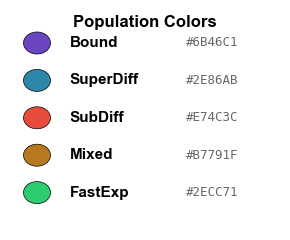

In [ ]:
# =============================================================================
# POPULATION COLOR KEY (save as SVG)
# =============================================================================
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# Population colors (consistent across all visualizations)
POP_COLORS = {
    'bound_stationary': '#6B46C1',           # Purple
    'superdiffusive_transport': '#2E86AB',   # Blue
    'subdiffusive_motion': '#E74C3C',        # Red
    'mixed_exploratory_bound': '#B7791F',    # Gold/Brown
    'fast_exploratory': '#2ECC71',           # Green
}

POP_LABELS = {
    'bound_stationary': 'Bound',
    'superdiffusive_transport': 'SuperDiff',
    'subdiffusive_motion': 'SubDiff',
    'mixed_exploratory_bound': 'Mixed',
    'fast_exploratory': 'FastExp',
}

# Create figure
fig, ax = plt.subplots(figsize=(3, 2.5))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')

# Draw legend entries
y_positions = [0.85, 0.68, 0.51, 0.34, 0.17]
pop_order = ['bound_stationary', 'superdiffusive_transport', 'subdiffusive_motion', recla
             'mixed_exploratory_bound', 'fast_exploratory']

for i, pop in enumerate(pop_order):
    color = POP_COLORS[pop]
    label = POP_LABELS[pop]
    y = y_positions[i]
    
    # Draw filled circle
    circle = Circle((0.1, y), 0.05, facecolor=color, edgecolor='black', linewidth=0.5)
    ax.add_patch(circle)
    
    # Add label
    ax.text(0.22, y, label, fontsize=11, fontweight='bold', va='center', ha='left')
    
    # Add hex code (smaller, gray)
    ax.text(0.65, y, color, fontsize=9, va='center', ha='left', color='#666666', 
            family='monospace')

# Title
ax.text(0.5, 0.98, 'Population Colors', fontsize=12, fontweight='bold', 
        va='top', ha='center')

plt.tight_layout()

# Save as SVG
save_path = OUTPUT_FOLDER / "population_color_key.svg"
fig.savefig(save_path, format='svg', transparent=True, bbox_inches='tight', dpi=150)
print(f"✅ Saved: {save_path}")

plt.show()